In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report

<h1>1. Dataset Exploration & Understanding</h1>

In [7]:
# number of partipants
'''
In the description there are
48 participants
'''

# Days recorded per participant
min_date = None
max_date = None

for file in os.listdir("./dataset/calendar/"):
    df = pd.read_csv(f"./dataset/calendar/{file}")
    if min_date == None and max_date == None:
        min_date = df['DATE'].min()
        max_date = df['DATE'].max()
    else:
        if df['DATE'].min() < min_date:
            min_date = df['DATE'].min()

        if df['DATE'].max() > max_date:
            max_date = df['DATE'].max()

print(f"Earliest Date: {min_date}")
print(f"Latest Date: {max_date}")
print()


# Demographic diversity (age, gender)

'''
48 undergrads and grad students
doesn't specify gender
'''

# Total datapoints and labels
 
total_datapoints = 0
total_labels = 0
for file in os.listdir("./dataset/sensing/gps/"):
    df = pd.read_csv(f"./dataset/sensing/gps/{file}")
    total_datapoints += df.shape[0]
    total_labels += len(df['provider'].unique())

print(f"Total Datapoints: {total_datapoints}")
print(f"Total Labels: {total_labels}")
print()

# Datapoints per label

per_label = pd.Series(dtype="float64")  

for file in os.listdir("./dataset/sensing/gps/"):
    df = pd.read_csv(f"./dataset/sensing/gps/{file}")

    counts = (
        df.groupby("provider", dropna=False)
          .agg(rows=("provider", 'size'))
    )

    per_label = per_label.add(counts['rows'], fill_value=0)

per_label = per_label.astype(int).sort_values(ascending=False)
print(per_label)

# Input streams (accelerometer, gyro, annotations, etc.) 

'''
time
provider
network_type
accuracy
latitude
longitude
altitude
bearing
speed
travelstate
'''

Earliest Date: 03/27/2013
Latest Date: 6/8/2013

Total Datapoints: 202877
Total Labels: 117

wifi    187613
NaN      10744
cell      4520
dtype: int64


'\ntime\nprovider\nnetwork_type\naccuracy\nlatitude\nlongitude\naltitude\nbearing\nspeed\ntravelstate\n'

<h1>2. Annotation & Signal Exploration</h1>

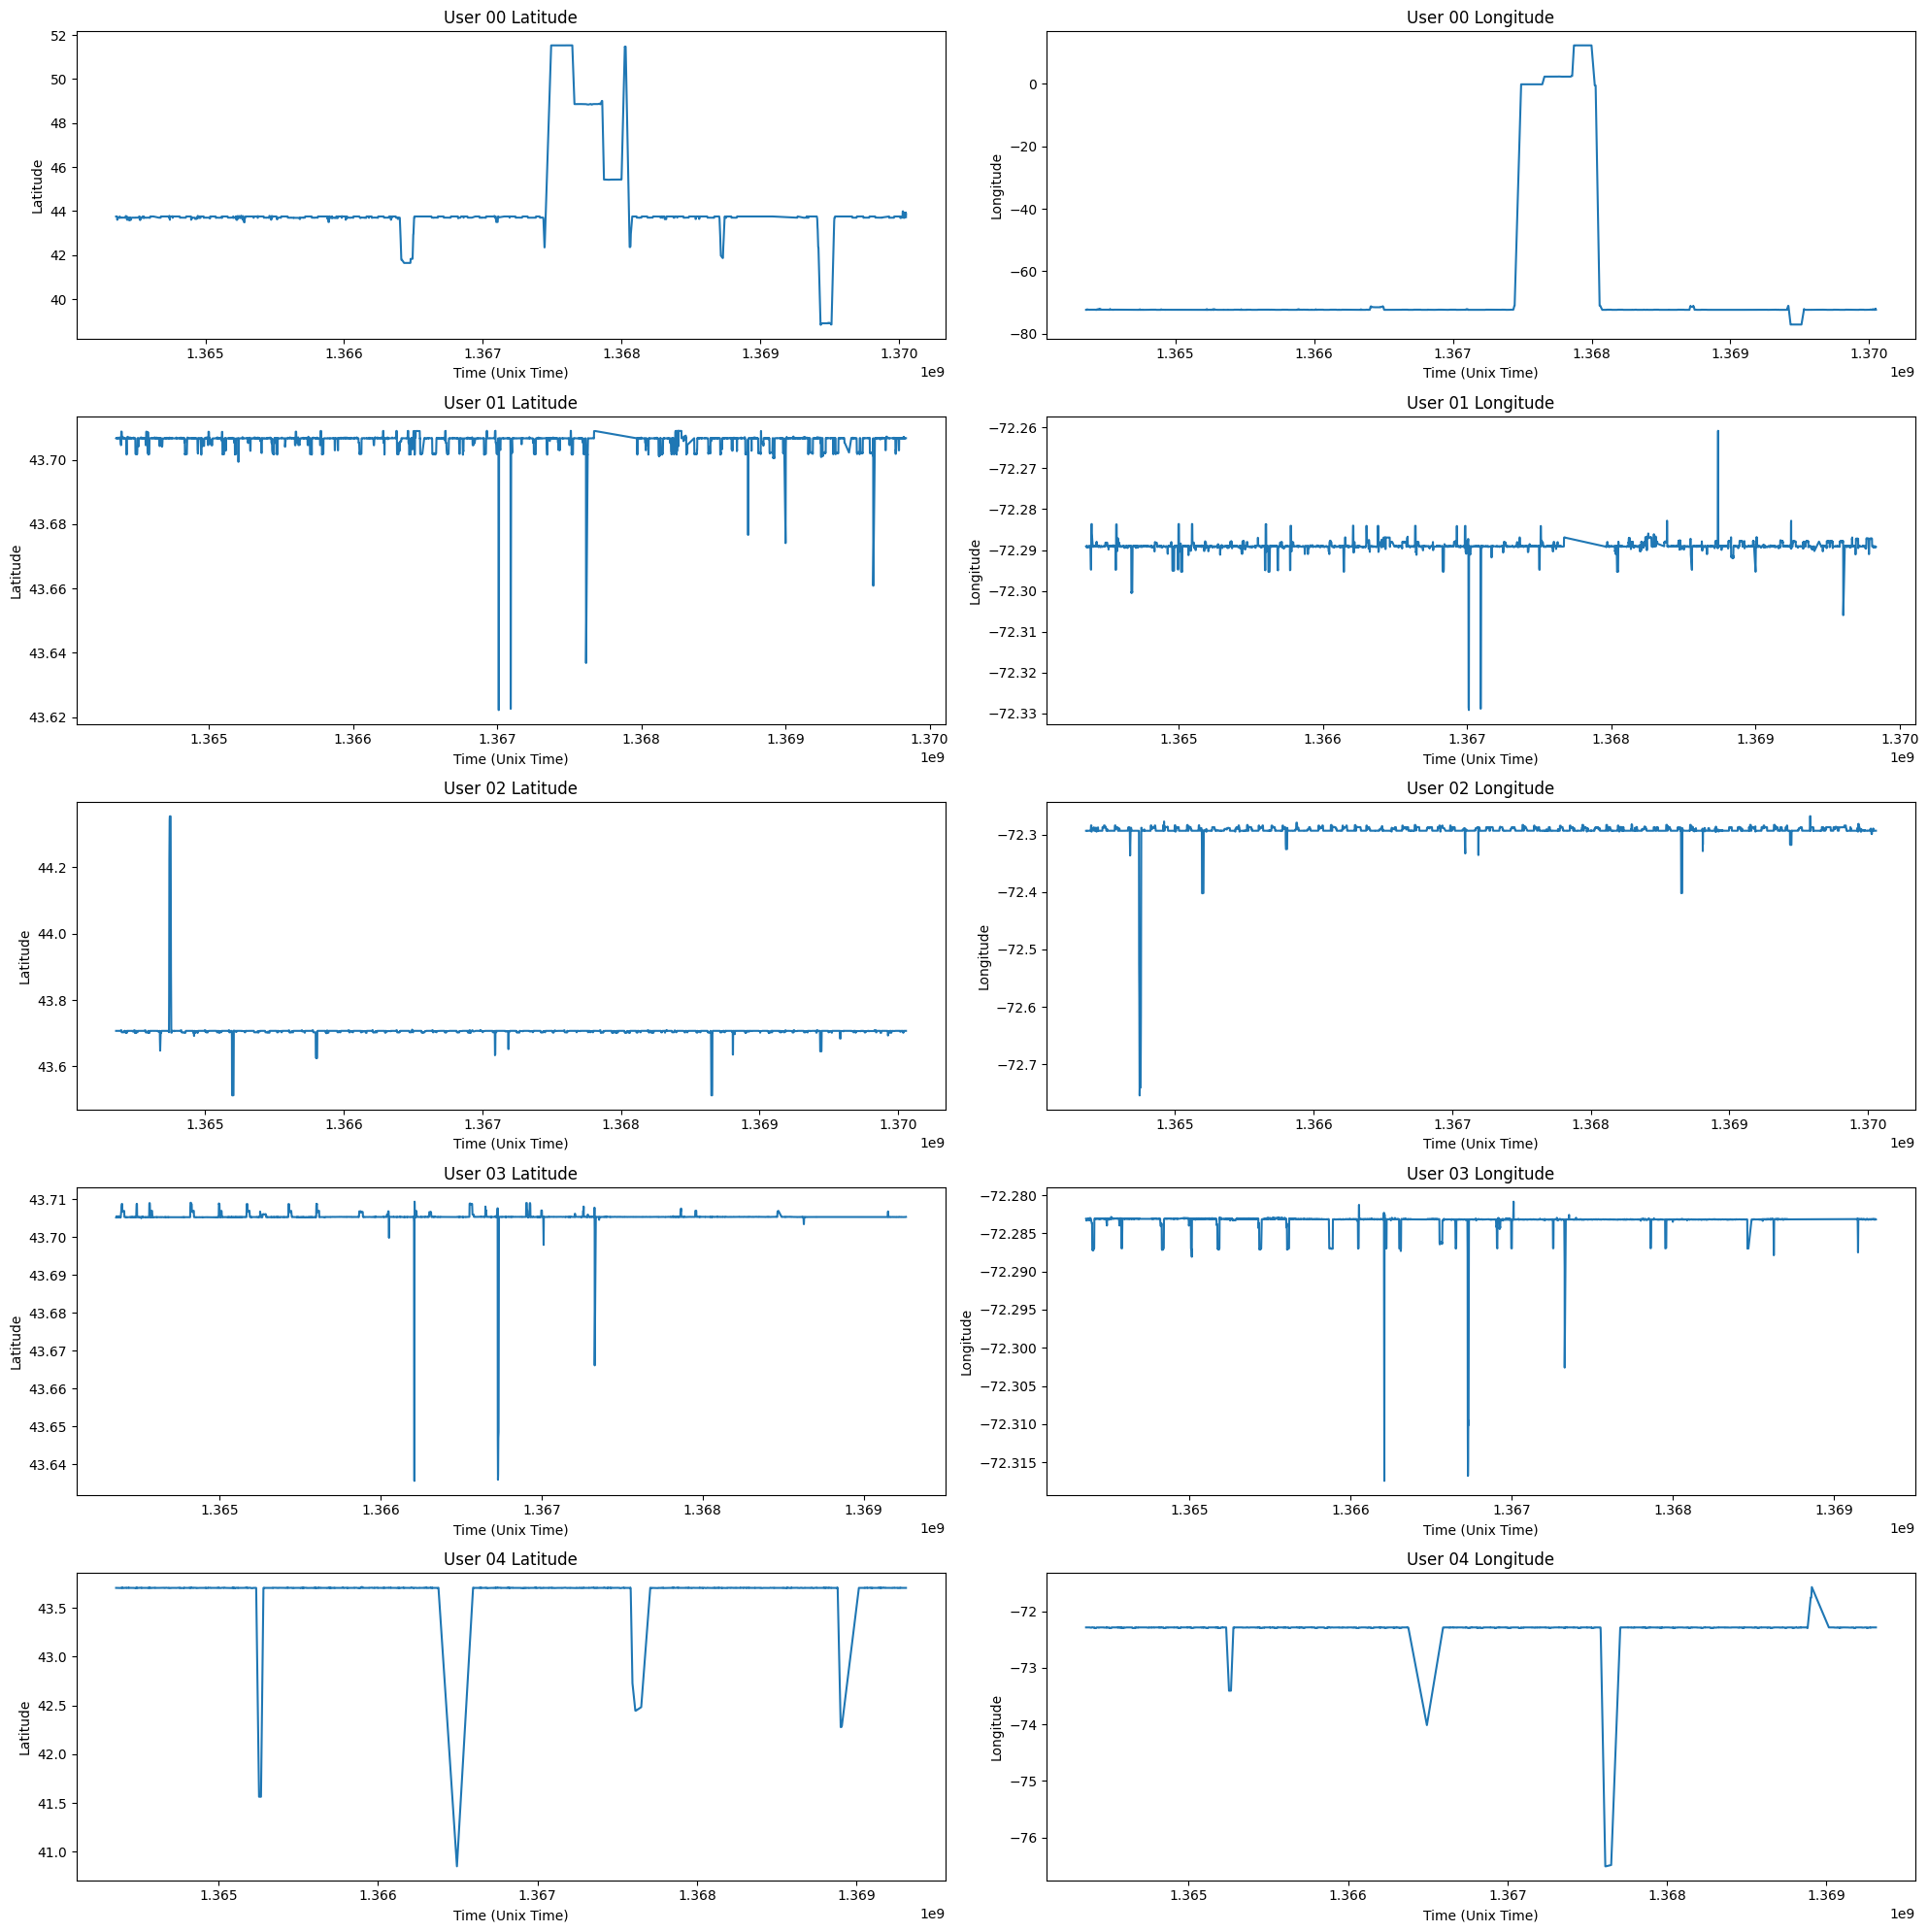

In [168]:
# General latitude and longitude plots
fig, axes = plt.subplots(5, 2, figsize=(20,20))

for i,file in enumerate(os.listdir("./dataset/sensing/gps/")):
    df = pd.read_csv(f"./dataset/sensing/gps/{file}", index_col=False)
    user = re.findall(r'\d+', file)[0]
    axes[i][0].plot(df['time'], df['latitude'])
    axes[i][0].set_title('User ' + str(user) + ' Latitude')
    axes[i][0].set_xlabel('Time (Unix Time)')
    axes[i][0].set_ylabel('Latitude')
    axes[i][1].plot(df['time'], df['longitude'])
    axes[i][1].set_title('User ' + str(user) + ' Longitude')  
    axes[i][1].set_xlabel('Time (Unix Time)')
    axes[i][1].set_ylabel('Longitude')  

    if i == 4:  # limit to first 5 users
        break

plt.tight_layout()
plt.show()

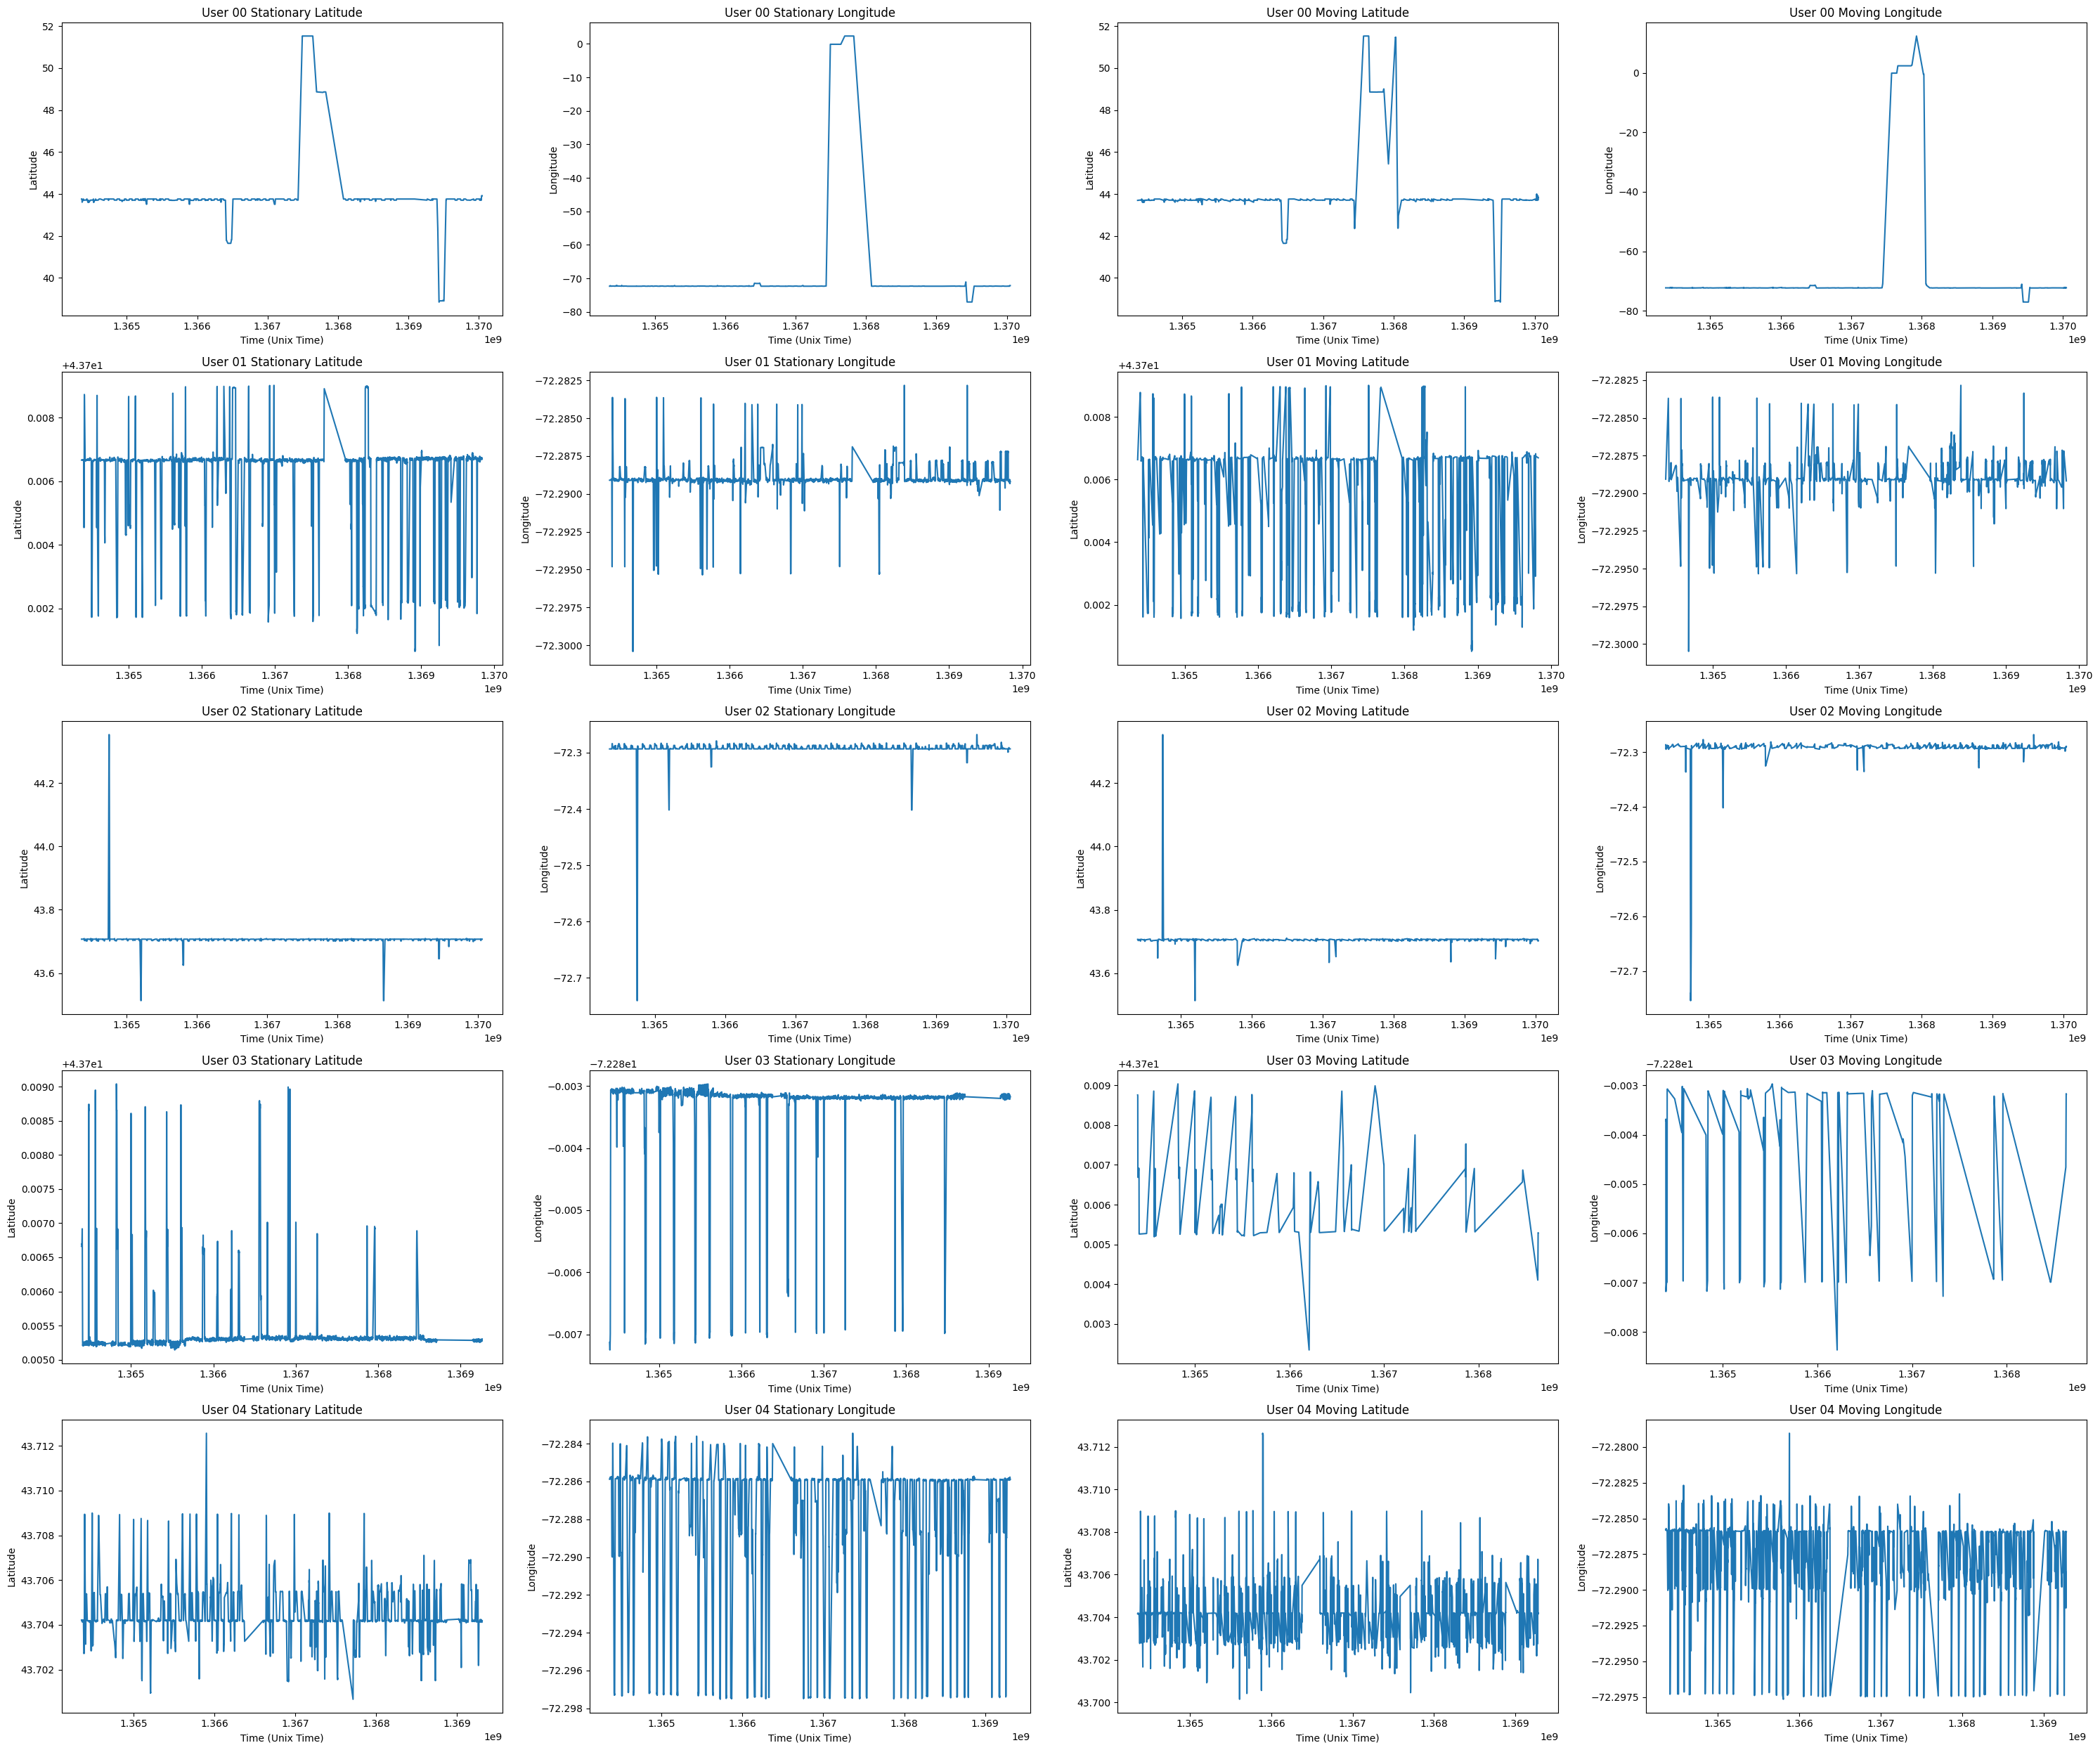

In [169]:
# Longitude and latitude plots based on travel state

fig, axes = plt.subplots(5, 4, figsize=(30,25))

for i,file in enumerate(os.listdir("./dataset/sensing/gps/")):
    df = pd.read_csv(f"./dataset/sensing/gps/{file}", index_col=False)
    user = re.findall(r'\d+', file)[0]
    stationary = df[df['travelstate'] == 'stationary']
    axes[i][0].plot(stationary['time'], stationary['latitude'])
    axes[i][0].set_title('User ' + str(user) + ' Stationary Latitude')
    axes[i][0].set_xlabel('Time (Unix Time)')
    axes[i][0].set_ylabel('Latitude')
    axes[i][1].plot(stationary['time'], stationary['longitude'])
    axes[i][1].set_title('User ' + str(user) + ' Stationary Longitude') 
    axes[i][1].set_xlabel('Time (Unix Time)')
    axes[i][1].set_ylabel('Longitude')

    moving = df[df['travelstate'] == 'moving']
    axes[i][2].plot(moving['time'], moving['latitude'])
    axes[i][2].set_title('User ' + str(user) + ' Moving Latitude')
    axes[i][2].set_xlabel('Time (Unix Time)')
    axes[i][2].set_ylabel('Latitude')
    axes[i][3].plot(moving['time'], moving['longitude'])
    axes[i][3].set_title('User ' + str(user) + ' Moving Longitude') 
    axes[i][3].set_xlabel('Time (Unix Time)')
    axes[i][3].set_ylabel('Longitude')
      

    if i == 4:  # preventing the graph from being too long since 2 travel states * 2 coords (lat/long) * 49 user graphs
        break 

plt.tight_layout()
plt.show()

<h1>3. Signal Preprocessing</h1>

In [ ]:
# Resampling to uniform frequency
resampled_df = pd.DataFrame()

for path in os.listdir("./dataset/sensing/gps"):
    df = pd.read_csv(f"./dataset/sensing/gps/{path}", sep=",", index_col=False, skipinitialspace=True)

    df["time"] = pd.to_numeric(df["time"], errors="coerce")
    df["timestamp"] = pd.to_datetime(df["time"], unit="s", utc=True, errors="coerce")
    df['user'] = re.findall(r'\d+', path)[0]

    base = os.path.splitext(path)[0]

    subject_str = base.replace("gps_u", "") 
    subject_id = int(subject_str)

    df = (df.dropna(subset=["timestamp"])
            .sort_values("timestamp")
            .drop_duplicates("timestamp"))

    # Does a 1 min resample
    # Picks the first record within each min
    g = (df.set_index("timestamp")
           .resample("1min")
           .first()
           .reset_index())

    g = g.dropna(subset=["time"])
    g["subject_id"] = subject_id

    resampled_df = pd.concat([resampled_df, g], ignore_index=True)

# Makes sure there is no duplicates for each min
# If there is a duplicate then the earliest timestamp is kept
resampled_df = (resampled_df.sort_values("timestamp").drop_duplicates(subset=["timestamp"], keep="first"))

resampled_df

,timestamp,time,provider,network_type,accuracy,latitude,longitude,altitude,bearing,speed,travelstate,user,subject_id
189837,2013-03-27 04:01:00+00:00,1.364357e+09,network,wifi,35.380,43.706128,-72.283232,0.000000,0.0,0.0,stationary,58,58
0,2013-03-27 04:02:00+00:00,1.364357e+09,network,wifi,24.000,43.759135,-72.329240,0.000000,0.0,0.0,stationary,00,0
4260,2013-03-27 04:03:00+00:00,1.364357e+09,network,wifi,67.993,43.706667,-72.289097,0.000000,0.0,0.0,stationary,01,1
89460,2013-03-27 04:04:00+00:00,1.364357e+09,network,wifi,49.000,43.703924,-72.290628,0.000000,0.0,0.0,moving,22,22
78353,2013-03-27 04:05:00+00:00,1.364357e+09,gps,None,15.000,43.707532,-72.289097,133.199997,0.0,0.0,None,18,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...
159671,2013-06-01 03:52:00+00:00,1.370059e+09,network,wifi,27.674,43.705107,-72.289242,0.000000,0.0,0.0,stationary,49,49
130700,2013-06-01 03:53:00+00:00,1.370059e+09,network,wifi,53.936,43.651667,-72.309955,0.000000,0.0,0.0,stationary,36,36
159672,2013-06-01 03:56:00+00:00,1.370059e+09,network,wifi,20.000,43.705157,-72.289342,0.000000,0.0,0.0,stationary,49,49
201617,2013-06-01 03:57:00+00:00,1.370059e+09,network,wifi,36.000,40.914270,-73.791962,0.000000,0.0,0.0,stationary,59,59


In [ ]:
# Apply filtering (noise reduction)
filtered_df = resampled_df

# Noise reduction on the lat and lon values
filtered_df["filtered_latitude"]  = filtered_df["latitude"].rolling(3, center=True, min_periods=1).median()
filtered_df["filtered_longitude"] = filtered_df["longitude"].rolling(3, center=True, min_periods=1).median()

filtered_df.head(10)

,timestamp,time,provider,network_type,accuracy,latitude,longitude,altitude,bearing,speed,travelstate,user,subject_id,filtered_latitude,filtered_longitude
189837,2013-03-27 04:01:00+00:00,1.364357e+09,network,wifi,35.380,43.706128,-72.283232,0.000000,0.0,0.0,stationary,58,58,43.732631,-72.306236
0,2013-03-27 04:02:00+00:00,1.364357e+09,network,wifi,24.000,43.759135,-72.329240,0.000000,0.0,0.0,stationary,00,0,43.706667,-72.289097
4260,2013-03-27 04:03:00+00:00,1.364357e+09,network,wifi,67.993,43.706667,-72.289097,0.000000,0.0,0.0,stationary,01,1,43.706667,-72.290628
89460,2013-03-27 04:04:00+00:00,1.364357e+09,network,wifi,49.000,43.703924,-72.290628,0.000000,0.0,0.0,moving,22,22,43.706667,-72.289097
78353,2013-03-27 04:05:00+00:00,1.364357e+09,gps,None,15.000,43.707532,-72.289097,133.199997,0.0,0.0,None,18,18,43.707240,-72.289097
82046,2013-03-27 04:06:00+00:00,1.364357e+09,network,wifi,25.183,43.707240,-72.286062,0.000000,0.0,0.0,stationary,19,19,43.707240,-72.288863
38067,2013-03-27 04:08:00+00:00,1.364357e+09,network,wifi,144.670,43.707154,-72.288863,0.000000,0.0,0.0,stationary,09,9,43.707154,-72.287018
121035,2013-03-27 04:09:00+00:00,1.364357e+09,network,wifi,23.877,43.706595,-72.287018,0.000000,0.0,0.0,stationary,35,35,43.706619,-72.287018
125351,2013-03-27 04:10:00+00:00,1.364357e+09,network,wifi,25.605,43.706619,-72.286985,0.000000,0.0,0.0,stationary,36,36,43.706599,-72.287010
132030,2013-03-27 04:14:00+00:00,1.364358e+09,network,wifi,24.342,43.706599,-72.287010,0.000000,0.0,0.0,stationary,41,41,43.706619,-72.287010


In [ ]:
all_interp = []

for sid, filtered_df in resampled_df.groupby("subject_id"):
    src = filtered_df.copy().sort_values("timestamp")

    lat_col = "filtered_latitude"  if "filtered_latitude"  in src.columns else "latitude"
    lon_col = "filtered_longitude" if "filtered_longitude" in src.columns else "longitude"

    full_idx = pd.date_range(
        src["timestamp"].min().floor("min"),
        src["timestamp"].max().ceil("min"),
        freq="1min", tz="UTC"
    )

    dfi = (src[["timestamp", lat_col, lon_col]]
             .rename(columns={lat_col: "lat_obs", lon_col: "lon_obs"})
             .set_index("timestamp")
             .reindex(full_idx))

    lat_i = dfi["lat_obs"].interpolate(method="time", limit_direction="both")
    lon_i = dfi["lon_obs"].interpolate(method="time", limit_direction="both")

    lat_final = dfi["lat_obs"].where(dfi["lat_obs"].notna(), lat_i)
    lon_final = dfi["lon_obs"].where(dfi["lon_obs"].notna(), lon_i)

    interploated_df = pd.DataFrame({
        "timestamp": full_idx,
        "latitude":  lat_final,
        "longitude": lon_final
    }).reset_index(drop=True)

    interploated_df["subject_id"] = sid

    other_columns = ["provider","network_type","accuracy","altitude","bearing","speed","travelstate"]
    columns = [c for c in other_columns if c in src.columns]

    extra_columns = pd.merge_asof(
        interploated_df.sort_values("timestamp"),
        src[["timestamp"] + columns].sort_values("timestamp"),
        on="timestamp",
        direction="nearest"
    )

    interploated_df = extra_columns.sort_values("timestamp").reset_index(drop=True)

    all_interp.append(interploated_df)

interploated_df = pd.concat(all_interp, ignore_index=True)

interploated_df.head()

,timestamp,latitude,longitude,subject_id,provider,network_type,accuracy,altitude,bearing,speed,travelstate
0,2013-03-27 04:02:00+00:00,43.706667,-72.289097,0,network,wifi,24.0,0.0,0.0,0.0,stationary
1,2013-03-27 04:03:00+00:00,43.706669,-72.289101,0,network,wifi,24.0,0.0,0.0,0.0,stationary
2,2013-03-27 04:04:00+00:00,43.706671,-72.289104,0,network,wifi,24.0,0.0,0.0,0.0,stationary
3,2013-03-27 04:05:00+00:00,43.706672,-72.289108,0,network,wifi,24.0,0.0,0.0,0.0,stationary
4,2013-03-27 04:06:00+00:00,43.706674,-72.289111,0,network,wifi,24.0,0.0,0.0,0.0,stationary


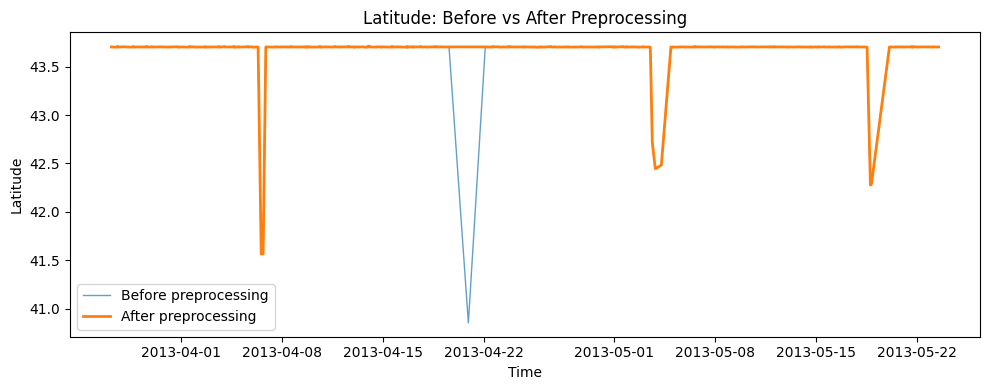

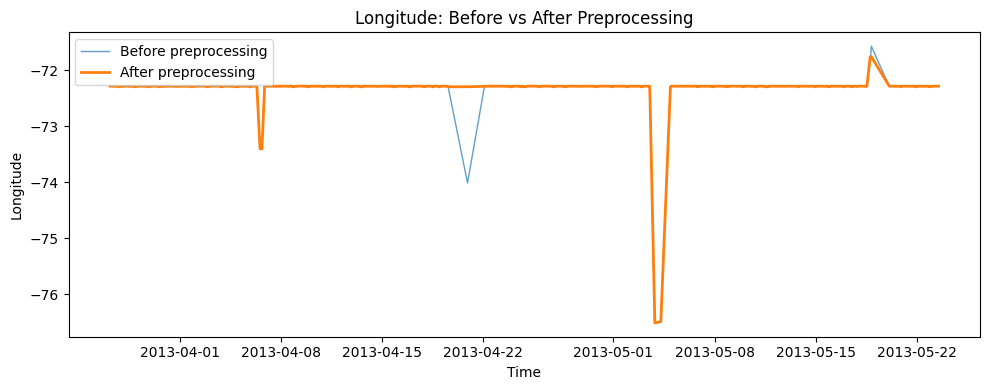

In [173]:
plt.figure(figsize=(10,4))
plt.plot(resampled_df["timestamp"], resampled_df["latitude"], label="Before preprocessing", linewidth=1, alpha=0.7)
plt.plot(interploated_df["timestamp"], interploated_df["latitude"], label="After preprocessing", linewidth=2)
plt.title("Latitude: Before vs After Preprocessing")
plt.xlabel("Time")
plt.ylabel("Latitude")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(resampled_df["timestamp"], resampled_df["longitude"], label="Before preprocessing", linewidth=1, alpha=0.7)
plt.plot(interploated_df["timestamp"], interploated_df["longitude"], label="After preprocessing", linewidth=2)
plt.title("Longitude: Before vs After Preprocessing")
plt.xlabel("Time")
plt.ylabel("Longitude")
plt.legend()
plt.tight_layout()
plt.show()


<h1>4. Windowing Strategies</h1>

• Implement one of two strategies:

 – Fixed/Sliding Windows: test ≥10 window sizes – 1.0

 – Event-Based/Dynamic Windows: propose and justify new segmentation – 1.0

• Provide rationale for chosen strategy (accuracy vs. interpretability) – 0.5

Number of days in data: 58
Number of fixed windows: 58


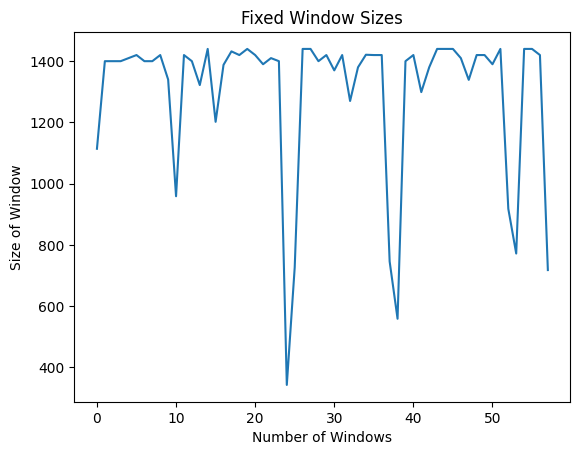

In [174]:
interploated_df = interploated_df.dropna(subset=['travelstate'])
print('Number of days in data:',len(interploated_df['timestamp'].dt.date.unique()))

# windows = 1 day since there are 58 separate days
fixedWindow = {}

for day, dataf in interploated_df.groupby(interploated_df['timestamp'].dt.date):
    fixedWindow[day] = dataf

print('Number of fixed windows:',len(fixedWindow))

plt.plot([i for i in range(len(fixedWindow.keys()))], [len(fixedWindow[i]) for i in fixedWindow])
plt.xlabel('Number of Windows')
plt.ylabel('Size of Window')
plt.title('Fixed Window Sizes')
plt.savefig(r"C:\Users\henry\Downloads\Plots\fixed_window.pdf", format="pdf", bbox_inches="tight")
plt.show()

Number of sliding windows: 115


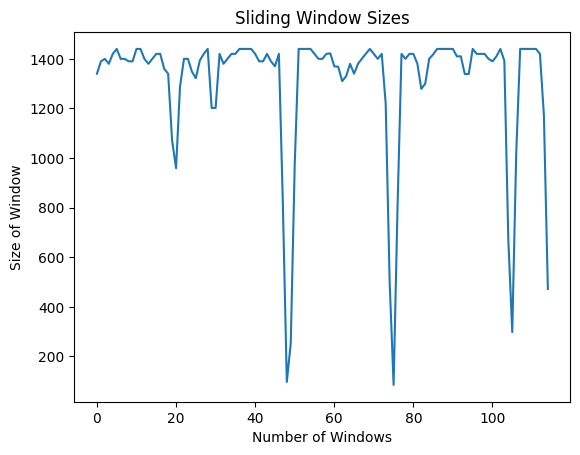

In [175]:
# sliding window = 1 day windows, 50% overlap
slidingWindow = {}
size = pd.Timedelta(days=1)
start = interploated_df['timestamp'].min()
index = 0
while start < interploated_df['timestamp'].max():
    end = start + size
    window = interploated_df[(interploated_df['timestamp'] >= start) & (interploated_df['timestamp'] < end)]
    slidingWindow[index] = window
    start += size / 2 # 50% overlap
    index += 1

print('Number of sliding windows:',len(slidingWindow))

plt.plot(slidingWindow.keys(), [len(slidingWindow[i]) for i in slidingWindow])
plt.xlabel('Number of Windows')
plt.ylabel('Size of Window')
plt.title('Sliding Window Sizes')
plt.savefig(r"C:\Users\henry\Downloads\Plots\sliding_windows.pdf", format="pdf", bbox_inches="tight")
plt.show()

Number of dynamic windows: 799


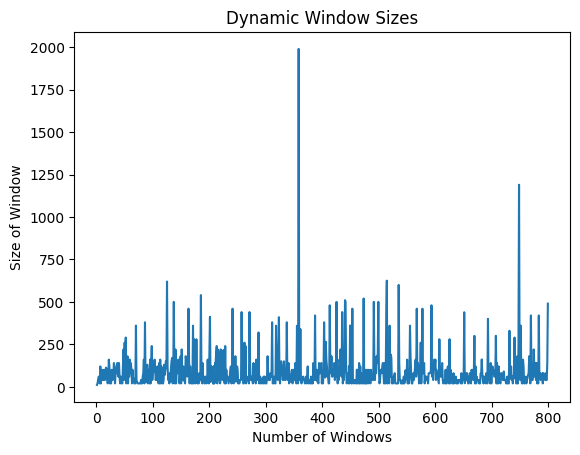

In [176]:
# Dynamic window; splitting based on travel state (i.e. window 1 = first batch of stationary, window 2 = first batch of walking, window 3 = second batch of stationary, etc)

transitions = (interploated_df['travelstate'] != interploated_df['travelstate'].shift()).cumsum()
dynamicWindows = {index: window for index, window in interploated_df.groupby(transitions)}

print('Number of dynamic windows:',len(dynamicWindows))

plt.plot(dynamicWindows.keys(), [len(dynamicWindows[i]) for i in dynamicWindows])
plt.xlabel('Number of Windows')
plt.ylabel('Size of Window')
plt.title('Dynamic Window Sizes')
plt.savefig(r"C:\Users\henry\Downloads\Plots\dyna_window.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [177]:
# just testing to see how many dynamic windows for just 1 user
'''for i,file in enumerate(os.listdir("./dataset/sensing/gps/")):
    df = pd.read_csv(f"./dataset/sensing/gps/{file}", index_col=False)
    transitions = (df['travelstate'] != df['travelstate'].shift()).cumsum()
    dynamicWindows = {index: window for index, window in df.groupby(transitions)}
    break

len(dynamicWindows)'''

'for i,file in enumerate(os.listdir("./dataset/sensing/gps/")):\n    df = pd.read_csv(f"./dataset/sensing/gps/{file}", index_col=False)\n    transitions = (df[\'travelstate\'] != df[\'travelstate\'].shift()).cumsum()\n    dynamicWindows = {index: window for index, window in df.groupby(transitions)}\n    break\n\nlen(dynamicWindows)'

<h1>5. Feature Extraction & Analysis</h1>

<h1>6. Modeling & Evaluation</h1>

• Implement classical ML models (Decision Tree, SVM, Naive Bayes, Random Forest, AdaBoost, XGBoost) – 1.0

• Document methodology (feature selection, model training, evaluation design) – 1.0

• Evaluate with standard splits (80/20, 70/30): precision, recall, accuracy, F1-macro – 1.0

• Include confusion matrices, error analysis, and member contributions – 0.5

• Write dataset, methodology, and results in Overleaf template (with tables and figures) – 0.5

In [178]:
#!pip install xgboost
#!pip install scikit-learn
    
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

Decision Tree Accuracy: 0.8530541937193586
              precision    recall  f1-score   support

      moving       0.84      0.83      0.84      6845
  stationary       0.86      0.87      0.87      8249

    accuracy                           0.85     15094
   macro avg       0.85      0.85      0.85     15094
weighted avg       0.85      0.85      0.85     15094



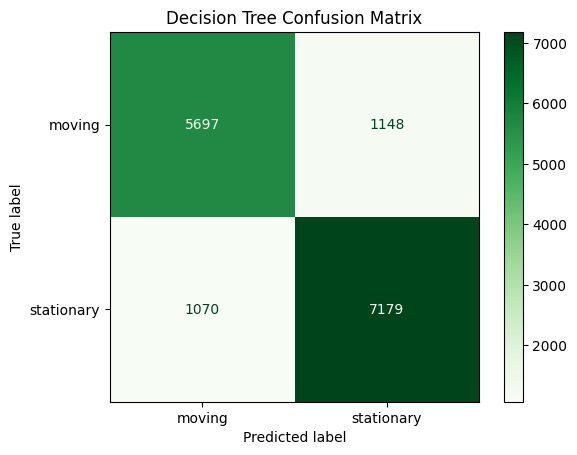

In [179]:
#interploated_df = interploated_df.dropna(subset=['travelstate'])
X = interploated_df[['latitude', 'longitude']]
y = interploated_df['travelstate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# no max depth: 84.91%, 84.27%
# max depth 5: 76.86%
# 10: 81.03%
# 20: 85.35%, 85.34%, 85.18%, 85.63%
# 30: 84.58%

tree = DecisionTreeClassifier(max_depth=20)
tree.fit(X_train_scaled, y_train)
y_pred = tree.predict(X_test_scaled)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['moving', 'stationary'])
disp.plot(cmap='Greens')
plt.title("Decision Tree Confusion Matrix")
plt.savefig(r"C:\Users\henry\Downloads\Plots\confusion_matrix_dtree.pdf", format="pdf", bbox_inches="tight")
plt.show()

SVM Accuracy: 0.681264078441765
              precision    recall  f1-score   support

      moving       0.65      0.64      0.64      6845
  stationary       0.70      0.72      0.71      8249

    accuracy                           0.68     15094
   macro avg       0.68      0.68      0.68     15094
weighted avg       0.68      0.68      0.68     15094



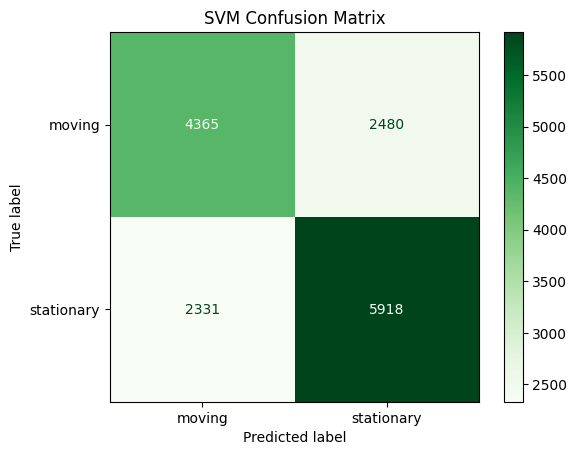

In [180]:
# rbf: 53.13%
# linear: 56.21%
# poly: 56.51% (like a minute faster too)
# sigmoid: 68.04%


svm = SVC(kernel="sigmoid")
svm.fit(X_train_scaled, y_train)
y_pred = svm.predict(X_test_scaled)
print("SVM Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['moving', 'stationary'])
disp.plot(cmap='Greens')
plt.title("SVM Confusion Matrix")
plt.show()

Naive Bayes Accuracy: 0.5645289519014178
              precision    recall  f1-score   support

      moving       0.93      0.04      0.08      6845
  stationary       0.56      1.00      0.71      8249

    accuracy                           0.56     15094
   macro avg       0.74      0.52      0.40     15094
weighted avg       0.72      0.56      0.43     15094



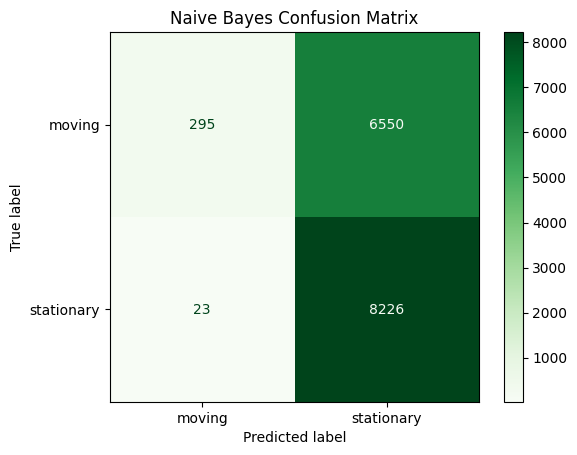

In [181]:
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)
y_pred = nb.predict(X_test_scaled)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['moving', 'stationary'])
disp.plot(cmap='Greens')
plt.title("Naive Bayes Confusion Matrix")
plt.savefig(r"C:\Users\henry\Downloads\Plots\confusion_matrix_nb.pdf", format="pdf", bbox_inches="tight")
plt.show()

Random Forest Accuracy: 0.873459652842189
              precision    recall  f1-score   support

      moving       0.86      0.86      0.86      6845
  stationary       0.88      0.89      0.88      8249

    accuracy                           0.87     15094
   macro avg       0.87      0.87      0.87     15094
weighted avg       0.87      0.87      0.87     15094



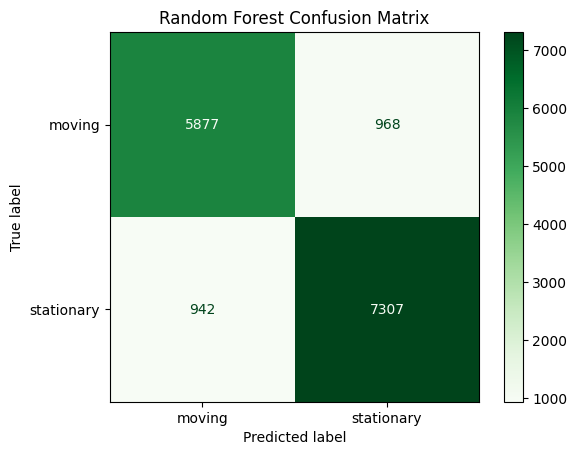

In [182]:
# n_estimators 100: 87.5%, 87.29%, 87.22%, 87.25%
# 200: 87.99%, 87.28%, 87.42%, 87.33%
# 300: 87.68%, 87.38%, 87.39%
# 500: 87.44%, 87.38%, 87.43%
# 1000: 87.32%, 87.25%

forest = RandomForestClassifier(n_estimators=200)
forest.fit(X_train_scaled, y_train)
y_pred = forest.predict(X_test_scaled)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['moving', 'stationary'])
disp.plot(cmap='Greens')
plt.title("Random Forest Confusion Matrix")
plt.show()

AdaBoost Accuracy: 0.747051808665695
              precision    recall  f1-score   support

      moving       0.71      0.74      0.73      6845
  stationary       0.78      0.76      0.77      8249

    accuracy                           0.75     15094
   macro avg       0.75      0.75      0.75     15094
weighted avg       0.75      0.75      0.75     15094



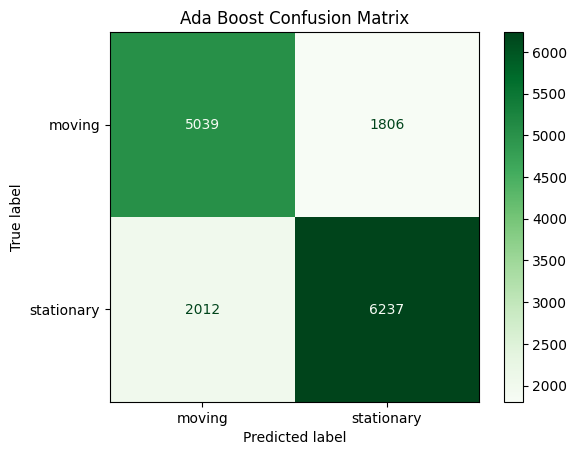

In [183]:
# default learning rate 1
# n_estimators 100: 76.28%
# 200: 77.09%
# 300: 77.54%, 76.56%
# 500: 76.76%, 77.41%
# 1000: 77.50%, 77.30%
# 2000: 78.4%
# 3000: 79.56%, 79.57%
# 5000: 78.61%

# learning rate 0.5
# 100: 75%
# 300: 75.91%

# learning rate 2
# 300: 32.85%

# learning rate 0.1
# 300: 75.28
# 200: 75.02%

ada = AdaBoostClassifier(n_estimators=3000)
ada.fit(X_train_scaled, y_train)
y_pred = ada.predict(X_test_scaled)
print("AdaBoost Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['moving', 'stationary'])
disp.plot(cmap='Greens')
plt.title("Ada Boost Confusion Matrix")
plt.savefig(r"C:\Users\henry\Downloads\Plots\confusion_matrix_ada.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [184]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

XGBoost Accuracy: 0.8404664104942361
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      6845
           1       0.85      0.87      0.86      8249

    accuracy                           0.84     15094
   macro avg       0.84      0.84      0.84     15094
weighted avg       0.84      0.84      0.84     15094



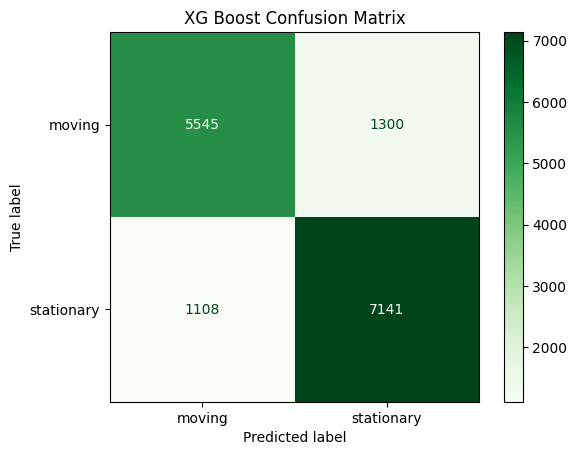

In [185]:
# n_estimators=100, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss' 80.75%
# n_estimators=200, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss' 82.03%, 82.06%
# n_estimators=500, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss' 83.17%
# n_estimators=1000, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss' 83.34%

# n_estimators=1000, learning_rate=0.5, eval_metric='logloss' 82.52%, 83.13%
# n_estimators=500, learning_rate=0.5, eval_metric='logloss' 83.42%, 83.42%
# n_estimators=200, learning_rate=0.5, eval_metric='logloss' 83.50%, 83.72%
# n_estimators=100, learning_rate=0.5, eval_metric='logloss' 83.14%

# n_estimators=100, learning_rate=1, eval_metric='logloss' 82.77%
# n_estimators=200, learning_rate=1, eval_metric='logloss' 83.36%
# n_estimators=500, learning_rate=1, eval_metric='logloss' 82.31%

xgb = XGBClassifier(n_estimators=200, learning_rate=0.5, eval_metric='logloss')
xgb.fit(X_train_scaled, y_train)
y_pred = xgb.predict(X_test_scaled)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Greens')
plt.title("XG Boost Confusion Matrix")
plt.savefig(r"C:\Users\henry\Downloads\Plots\confusion_matrix_xga.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [186]:
#!pip install tensorflow

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input, Conv1D, Flatten, Dropout, MaxPooling1D, SimpleRNN, TimeDistributed
from tensorflow.keras.utils import to_categorical
import numpy as np

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid') 
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=64)

Epoch 1/50


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


755/755 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5942 - loss: 0.6606 - val_accuracy: 0.6648 - val_loss: 0.6334
Epoch 2/50
755/755 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6901 - loss: 0.6139 - val_accuracy: 0.7048 - val_loss: 0.6018
Epoch 3/50
755/755 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7020 - loss: 0.5936 - val_accuracy: 0.7010 - val_loss: 0.5857
Epoch 4/50
755/755 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7102 - loss: 0.5830 - val_accuracy: 0.7114 - val_loss: 0.5770
Epoch 5/50
755/755 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7164 - loss: 0.5761 - val_accuracy: 0.7179 - val_loss: 0.5763
Epoch 6/50
755/755 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7195 - loss: 0.5750 - val_accuracy: 0.7149 - val_loss: 0.5712
Epoch 7/50
755/755 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7233 - loss: 0.5706 - val_accuracy: 0.7139 - val_loss: 0.5694
Epoch 8/50
755/755 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7242 - loss: 0.5698 - val_accuracy: 0.7169 - val_

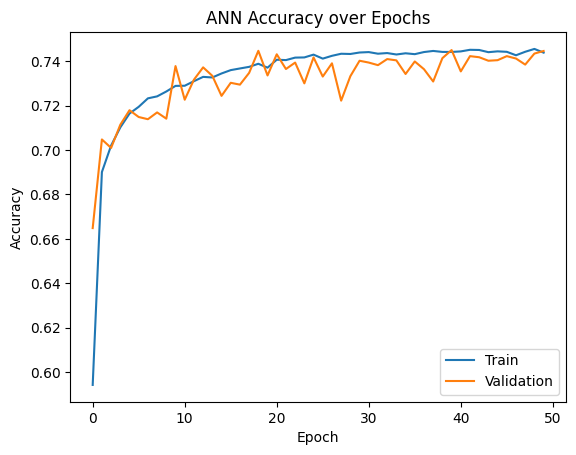

In [187]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ANN Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.savefig(r"C:\Users\henry\Downloads\Plots\ann_acc_plot.pdf", format="pdf", bbox_inches="tight")
plt.show()

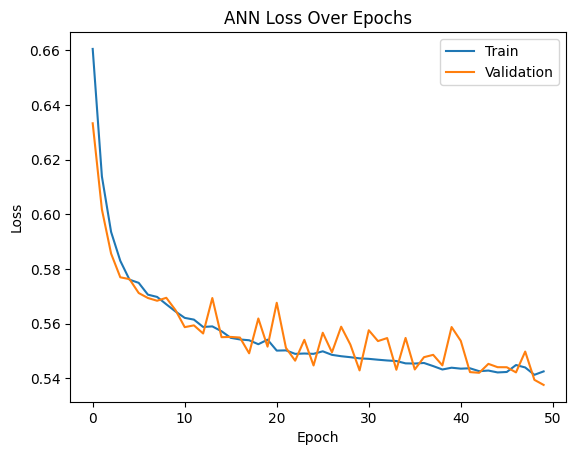

In [188]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ANN Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.savefig(r"C:\Users\henry\Downloads\Plots\ann_loss_plot.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [189]:
loss, acc = model.evaluate(X_test_scaled, y_test)
print("Accuracy:", acc)

472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7467 - loss: 0.5358
Accuracy: 0.746720552444458


472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


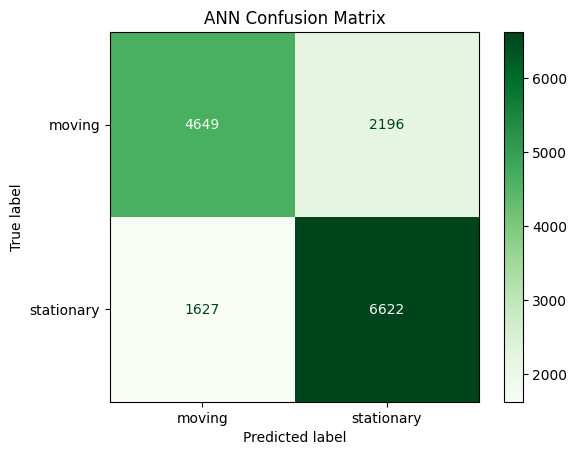

In [190]:
y_pred = model.predict(X_test_scaled)
y_pred = (y_pred >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['moving', 'stationary'])
disp.plot(cmap='Greens')
plt.title("ANN Confusion Matrix")
plt.savefig(r"C:\Users\henry\Downloads\Plots\confusion_matrix_ann.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [191]:
slidingX = []
slidingY = []

for k,v in slidingWindow.items():
  if len(v) >= 1000:
    slidingX.append(v[['latitude', 'longitude']].values[:1000])
    slidingY.append(v['travelstate'].values[0])

slidingX = np.array(slidingX)
slidingY = np.array(slidingY)

slidingY = le.fit_transform(slidingY)

In [ ]:
model2 = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(1000, 2)),
    MaxPooling1D(pool_size=2),

    Conv1D(128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),

    Conv1D(256, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model2.fit(slidingX, slidingY, epochs=50, validation_split=0.2, batch_size=64)

Epoch 1/50


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 389ms/step - accuracy: 0.4940 - loss: 20.9764 - val_accuracy: 0.4762 - val_loss: 45.2165
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.5422 - loss: 29.3229 - val_accuracy: 0.5238 - val_loss: 5.9869
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.4578 - loss: 6.0828 - val_accuracy: 0.4762 - val_loss: 0.7510
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.5060 - loss: 1.9351 - val_accuracy: 0.4762 - val_loss: 2.2060
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.5060 - loss: 1.7841 - val_accuracy: 0.5238 - val_loss: 2.0528
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.4819 - loss: 2.4289 - val_accuracy: 0.5238 - val_loss: 0.7059
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.4819 - loss: 0.9254 - val_accuracy: 0.4762 - val_loss: 1.5497
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.5181 - loss: 1.4948 - val_accuracy: 0.4762 - val_loss: 1.0856


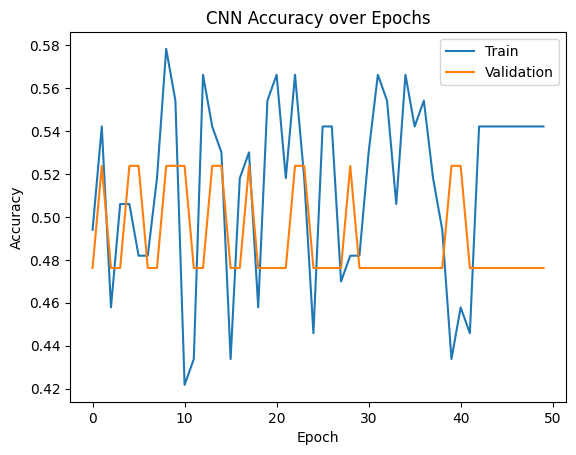

In [193]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.savefig(r"C:\Users\henry\Downloads\Plots\cnn_acc_plot.pdf", format="pdf", bbox_inches="tight")
plt.show()

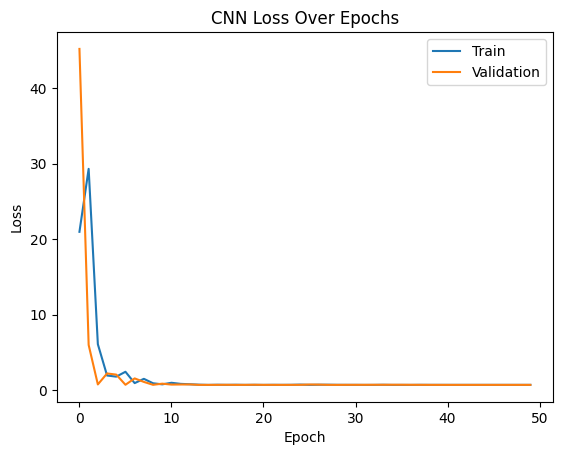

In [194]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.savefig(r"C:\Users\henry\Downloads\Plots\cnn_loss_plot.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [195]:
X_train, X_test, y_train, y_test = train_test_split(slidingX, slidingY, test_size=0.2)

loss, acc = model2.evaluate(X_test, y_test)
print("Accuracy:", acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4762 - loss: 0.6932
Accuracy: 0.4761904776096344


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


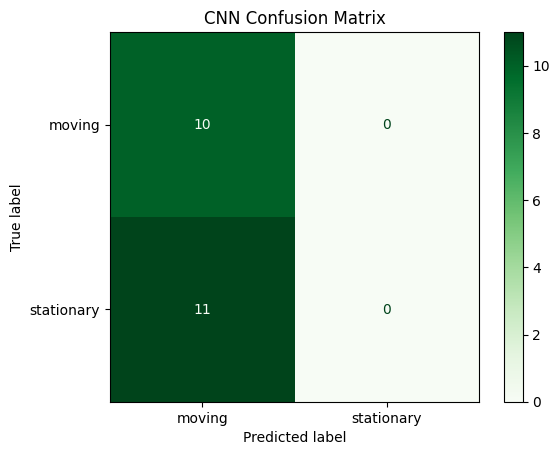

In [196]:
y_pred = model2.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Greens')
plt.title('CNN Confusion Matrix')
plt.savefig(r"C:\Users\henry\Downloads\Plots\confusion_matrix_cnn.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [197]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking

model3 = Sequential([
    Masking(mask_value=0., input_shape=(1000, 2)), 
    LSTM(64, return_sequences=False), 
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model3.fit(slidingX, slidingY, epochs=50, validation_split=0.2, batch_size=64)


Epoch 1/50


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 758ms/step - accuracy: 0.5422 - loss: 0.8077 - val_accuracy: 0.4762 - val_loss: 0.7724
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 373ms/step - accuracy: 0.5542 - loss: 0.7400 - val_accuracy: 0.4762 - val_loss: 0.7409
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 345ms/step - accuracy: 0.5783 - loss: 0.7048 - val_accuracy: 0.4762 - val_loss: 0.7201
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 362ms/step - accuracy: 0.4819 - loss: 0.7116 - val_accuracy: 0.4762 - val_loss: 0.7075
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 348ms/step - accuracy: 0.5542 - loss: 0.6752 - val_accuracy: 0.4762 - val_loss: 0.7002
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 352ms/step - accuracy: 0.5301 - loss: 0.7011 - val_accuracy: 0.4762 - val_loss: 0.6958
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 403ms/step - accuracy: 0.5181 - loss: 0.6976 - val_accuracy: 0.5238 - val_loss: 0.6931
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 366ms/step - accuracy: 0.5783 - loss: 0.7073 - val_accuracy: 0.5238 - val_loss: 0.6922
Epo

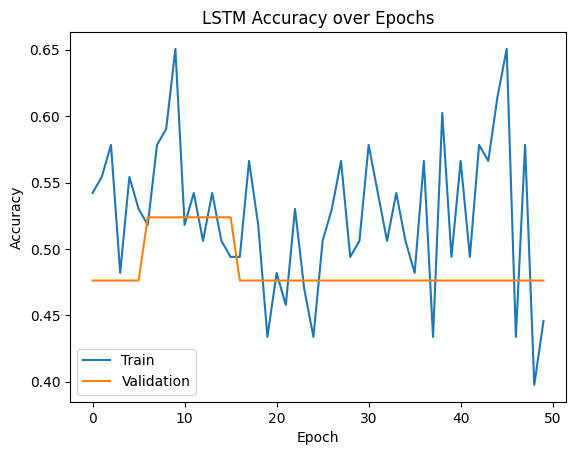

In [198]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('LSTM Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.savefig(r"C:\Users\henry\Downloads\Plots\lstm_acc_plot.pdf", format="pdf", bbox_inches="tight")
plt.show()

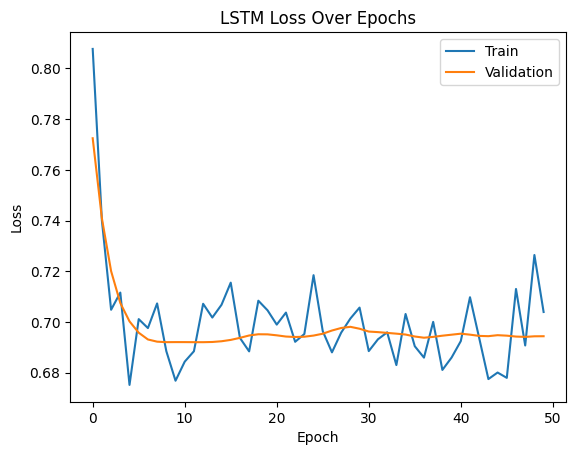

In [199]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.savefig(r"C:\Users\henry\Downloads\Plots\lstm_loss_plot.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [200]:
loss, acc = model3.evaluate(X_test, y_test)
print("Accuracy:", acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.4762 - loss: 0.6944
Accuracy: 0.4761904776096344


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


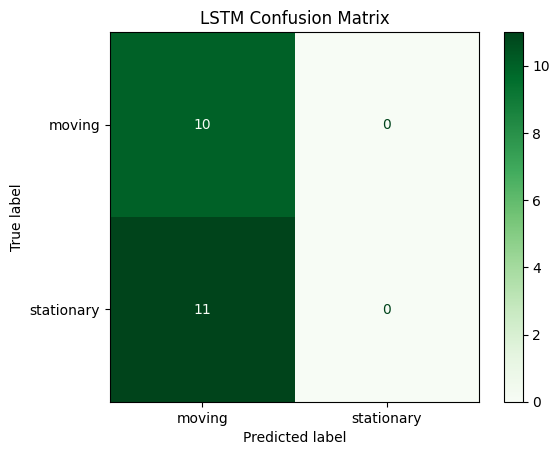

In [201]:
y_pred = model3.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Greens')
plt.title("LSTM Confusion Matrix")
plt.savefig(r"C:\Users\henry\Downloads\Plots\confusion_matrix_lstm.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [203]:
model4 = Sequential([
    SimpleRNN(64, return_sequences=False, input_shape=(1000, 2)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model4.fit(slidingX, slidingY, epochs=50, batch_size=64, validation_split=0.2)

Epoch 1/50


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 454ms/step - accuracy: 0.3855 - loss: 0.7209 - val_accuracy: 0.4762 - val_loss: 0.6951
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.5422 - loss: 0.6916 - val_accuracy: 0.4762 - val_loss: 0.7196
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5422 - loss: 0.6953 - val_accuracy: 0.4762 - val_loss: 0.7355
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.5422 - loss: 0.7028 - val_accuracy: 0.4762 - val_loss: 0.7321
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.5422 - loss: 0.7006 - val_accuracy: 0.4762 - val_loss: 0.7176
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.5422 - loss: 0.6941 - val_accuracy: 0.4762 - val_loss: 0.7041
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.5422 - loss: 0.6890 - val_accuracy: 0.4762 - val_loss: 0.6961
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.5422 - loss: 0.6907 - val_accuracy: 0.5238 - val_loss: 0.6928
Epo

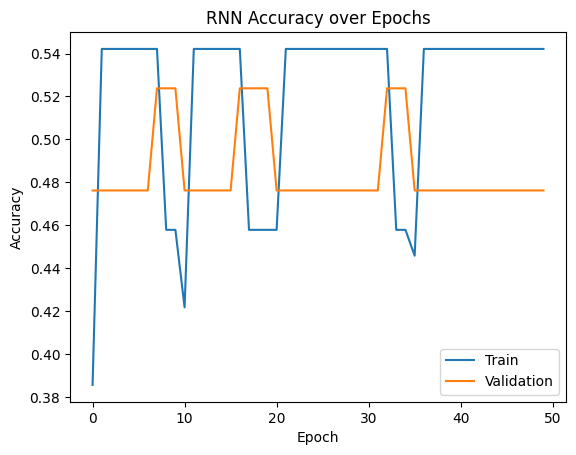

In [204]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('RNN Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.savefig(r"C:\Users\henry\Downloads\Plots\rnn_acc_plot.pdf", format="pdf", bbox_inches="tight")

plt.show()

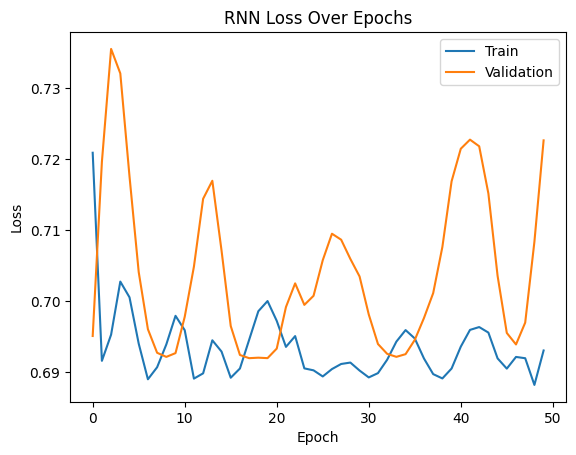

In [205]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('RNN Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.savefig(r"C:\Users\henry\Downloads\Plots\rnn_loss_plot.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [206]:
loss, acc = model4.evaluate(X_test, y_test)
print("Accuracy:", acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.4762 - loss: 0.7226
Accuracy: 0.4761904776096344


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


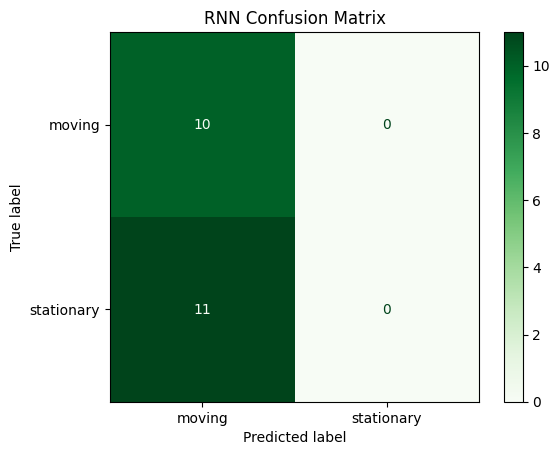

In [207]:
y_pred = model4.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['moving', 'stationary'])
disp.plot(cmap='Greens')
plt.title("RNN Confusion Matrix")
plt.savefig(r"C:\Users\henry\Downloads\Plots\confusion_matrix_rnn.pdf", format="pdf", bbox_inches="tight")
plt.show()

Section 5 - Validation (LOEO, LOSO)

Leave-One-Subject-Out

c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
User 00 Accuracy: 0.6772247552871704


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
User 01 Accuracy: 0.7795698642730713


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
User 02 Accuracy: 0.8231220245361328


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
User 03 Accuracy: 0.7523727416992188


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
User 04 Accuracy: 0.7559210658073425


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
User 05 Accuracy: 0.6848577857017517


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
User 07 Accuracy: 0.722663402557373


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
User 08 Accuracy: 0.7943301796913147


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
User 09 Accuracy: 0.6848609447479248


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
User 10 Accuracy: 0.7180585265159607


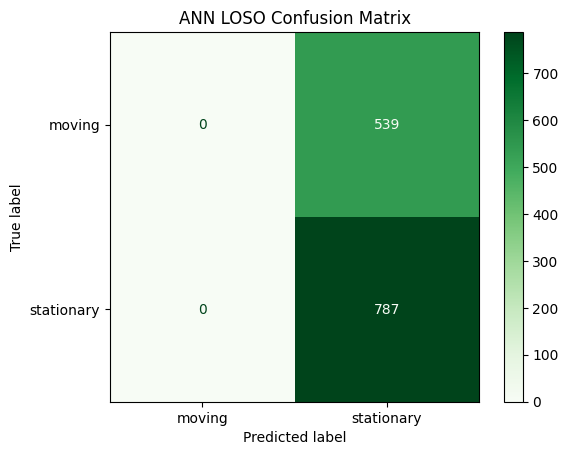

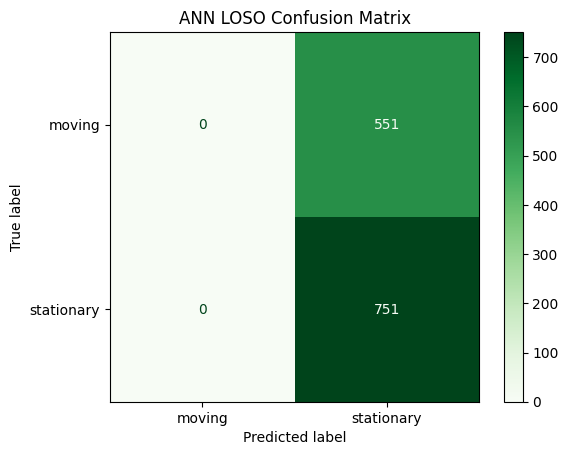

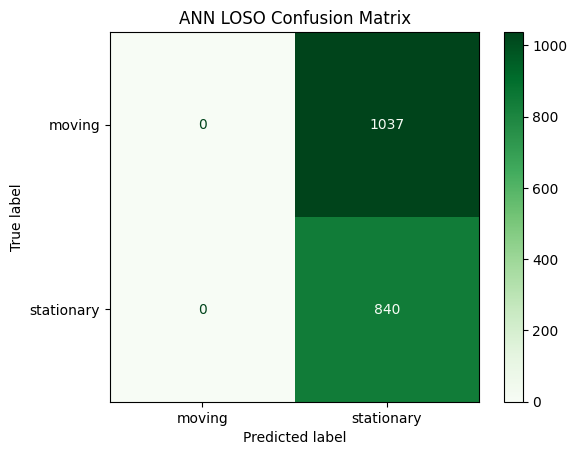

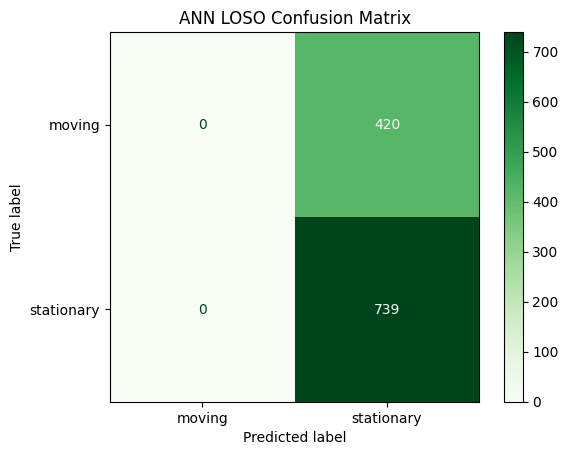

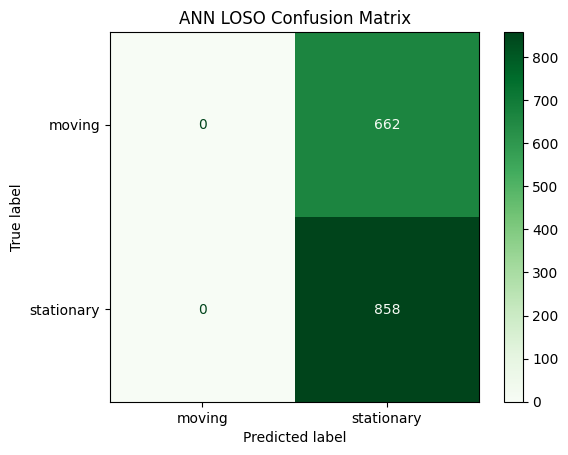

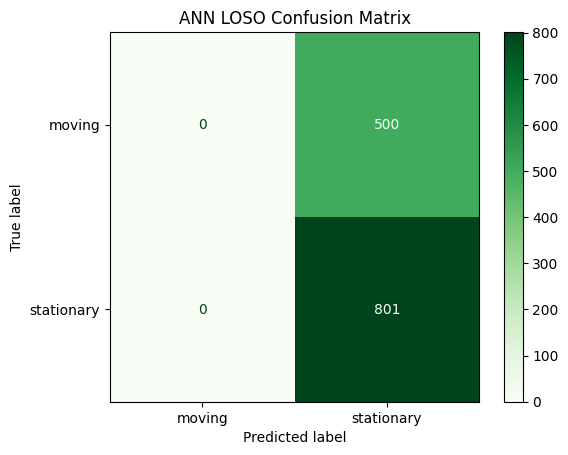

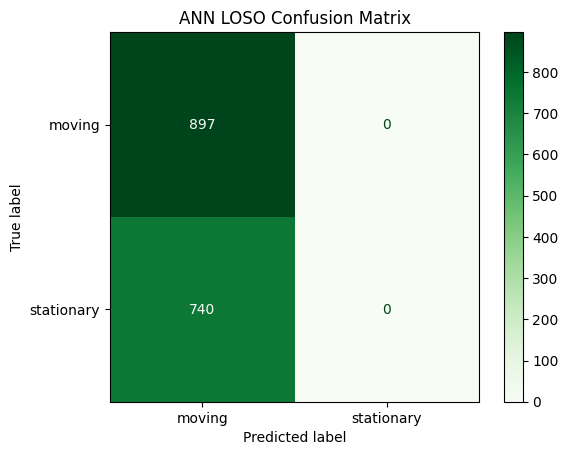

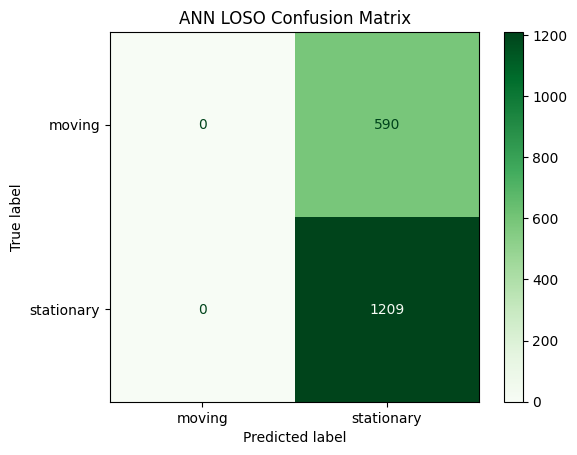

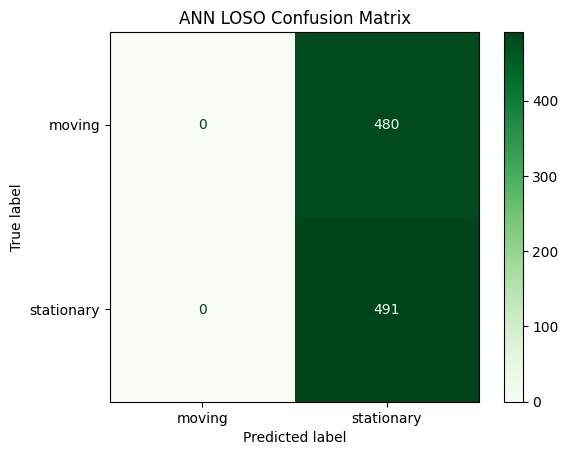

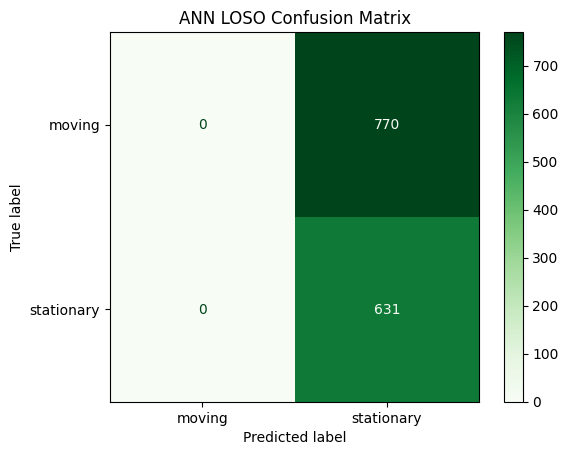

In [208]:
# LOSO
accuracies = {}
losses = {}
for user in ['00','01','02','03','04','05','07','08','09', '10']:
    test_df = interploated_df[interploated_df['user'] == user]
    train_df = interploated_df[interploated_df['user'] != user]

    X_train = np.stack(train_df[['latitude', 'longitude']].values)
    y_train = np.stack(train_df['travelstate'].values)
    X_test  = np.stack(test_df[['latitude', 'longitude']].values)
    y_test  = np.stack(test_df['travelstate'].values)

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    y_train = le.fit_transform(y_train)
    y_test = le.fit_transform(y_test)

    model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid') 
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=64, verbose=0)

    loss, acc = model.evaluate(X_test_scaled, y_test, verbose=0)

    y_pred = model.predict(X_test)
    y_pred = (y_pred >= 0.5).astype(int)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['moving', 'stationary'])
    disp.plot(cmap='Greens')
    plt.title("ANN LOSO Confusion Matrix")
    plt.savefig(fr"C:\Users\henry\Downloads\Plots\confusion_matrix_ann_loso_{user}.pdf", format="pdf", bbox_inches="tight")
    
    print("User",user,"Accuracy:", acc)   
    accuracies[user] = acc 
    losses[user] = loss
    

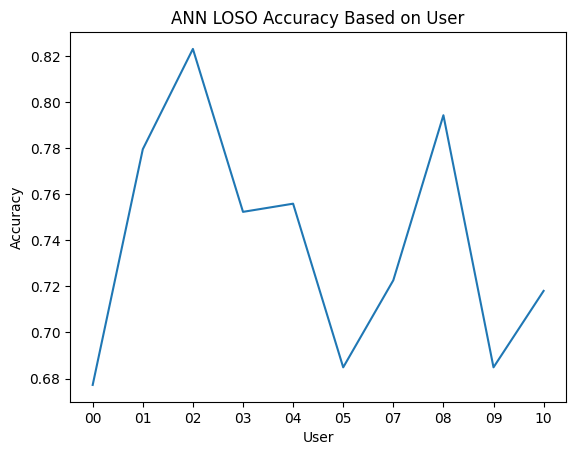

In [209]:
plt.plot(accuracies.keys(), accuracies.values())
plt.xlabel('User')
plt.ylabel('Accuracy')
plt.title('ANN LOSO Accuracy Based on User')
plt.savefig(r"C:\Users\henry\Downloads\Plots\ann_loso.pdf", format="pdf", bbox_inches="tight")
plt.show()

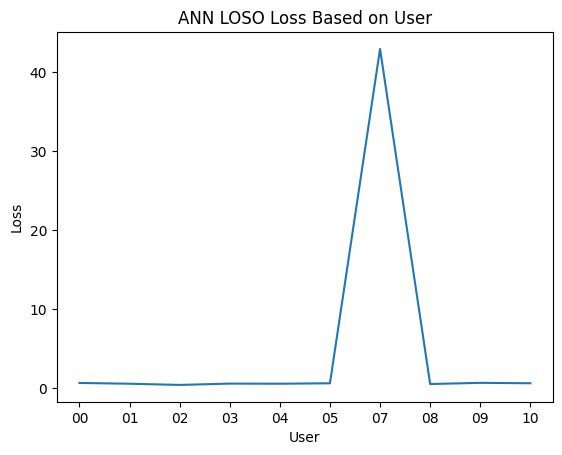

In [210]:
plt.plot(losses.keys(), losses.values())
plt.xlabel('User')
plt.ylabel('Loss')
plt.title('ANN LOSO Loss Based on User')
plt.savefig(r"C:\Users\henry\Downloads\Plots\ann_loso_loss.pdf", format="pdf", bbox_inches="tight")
plt.show()

c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
User 00 Accuracy: 0.6711915731430054


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
User 01 Accuracy: 0.7849462628364563


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
User 02 Accuracy: 0.8327117562294006


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
User 03 Accuracy: 0.7506471276283264


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
User 04 Accuracy: 0.7513157725334167


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
User 05 Accuracy: 0.6771714091300964


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
User 07 Accuracy: 0.7477092146873474


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
User 08 Accuracy: 0.7715397477149963


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
User 09 Accuracy: 0.7116374969482422


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
User 10 Accuracy: 0.7287651896476746


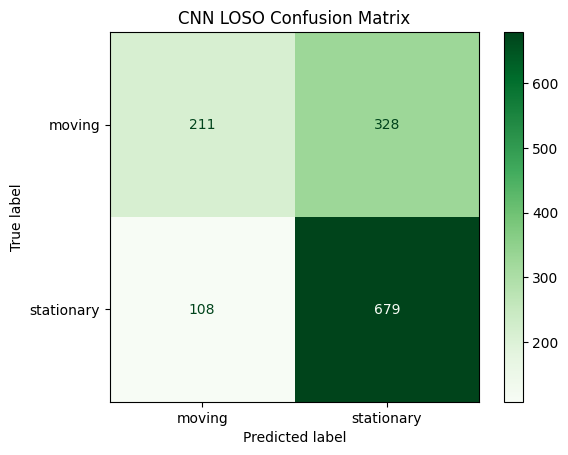

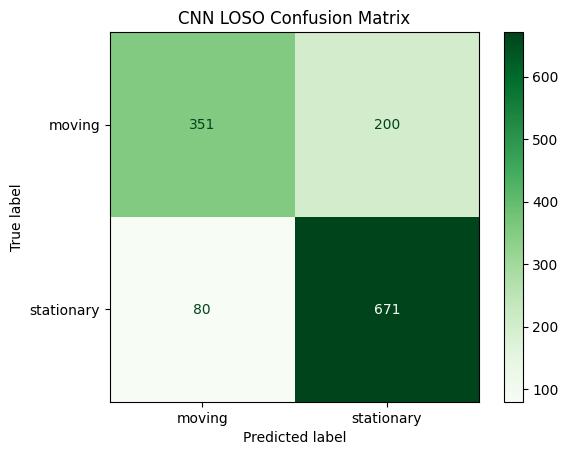

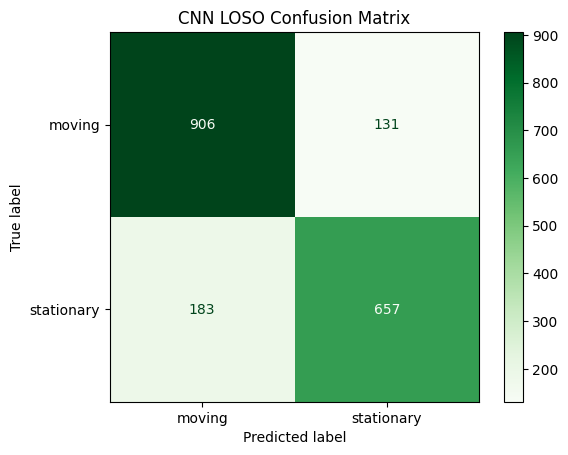

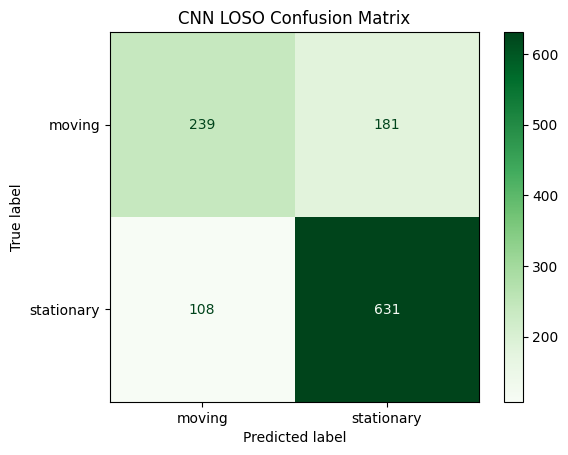

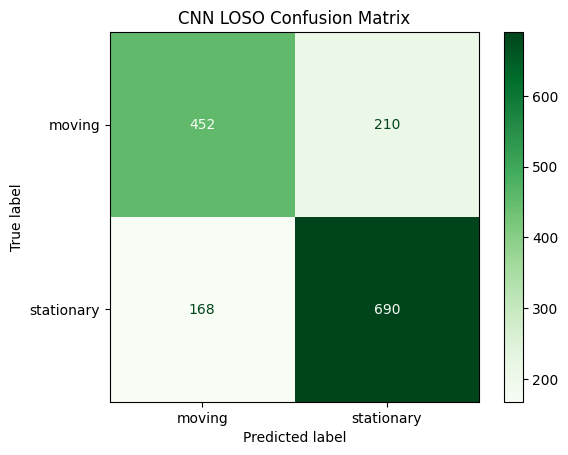

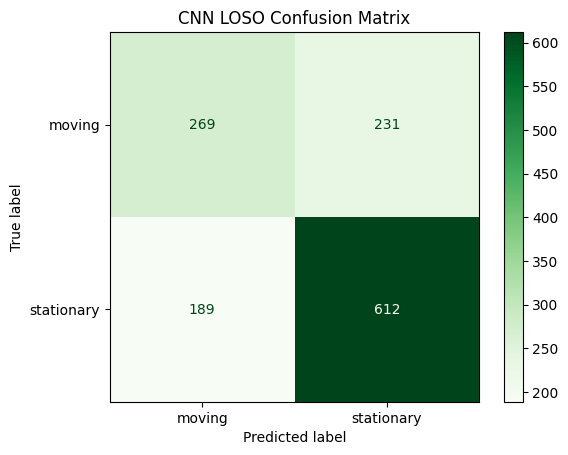

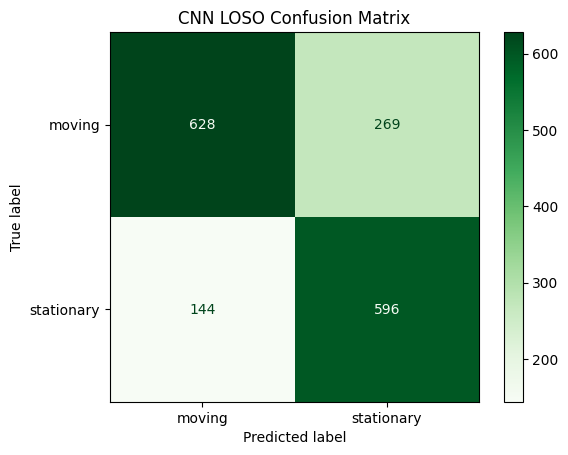

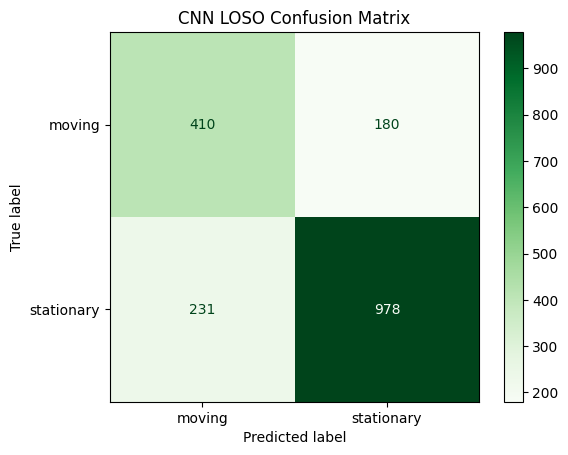

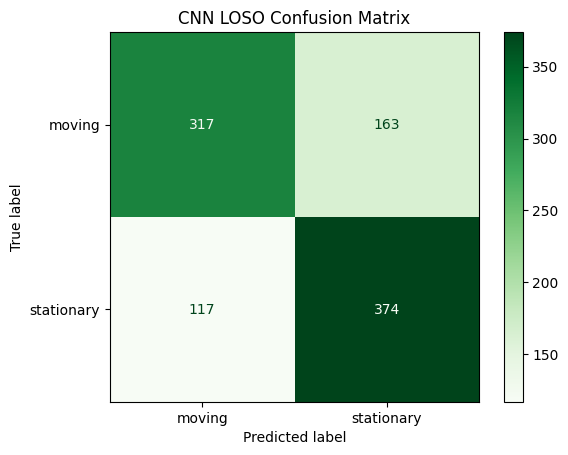

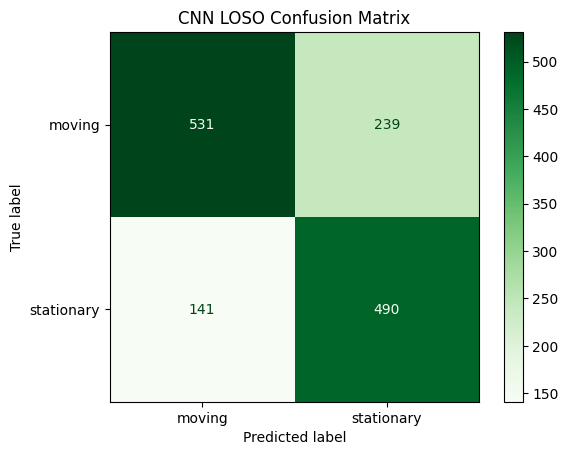

In [212]:
# LOSO
accuracies = {}
losses = {}
for user in ['00','01','02','03','04','05','07','08','09', '10']:
    test_df = interploated_df[interploated_df['user'] == user]
    train_df = interploated_df[interploated_df['user'] != user]

    X_train = np.stack(train_df[['latitude', 'longitude']].values)
    y_train = np.stack(train_df['travelstate'].values)
    X_test  = np.stack(test_df[['latitude', 'longitude']].values)
    y_test  = np.stack(test_df['travelstate'].values)

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_scaled  = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    y_train = le.fit_transform(y_train)
    y_test = le.fit_transform(y_test)

    model5 = Sequential([
    Conv1D(32, kernel_size=1, activation='relu', input_shape=(1, X_train_scaled.shape[2])),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
    ])
    
    model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model5.fit(X_train_scaled, y_train, epochs=50, batch_size=64, verbose=0)

    y_pred = model5.predict(X_test_scaled)
    y_pred = (y_pred >= 0.5).astype(int)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['moving', 'stationary'])
    disp.plot(cmap='Greens')
    plt.title("CNN LOSO Confusion Matrix")
    plt.savefig(fr"C:\Users\henry\Downloads\Plots\confusion_matrix_cnn_loso_{user}.pdf", format="pdf", bbox_inches="tight")

    loss, acc = model5.evaluate(X_test_scaled, y_test, verbose=0)
    print("User",user,"Accuracy:", acc)   
    accuracies[user] = acc
    losses[user] = loss

    

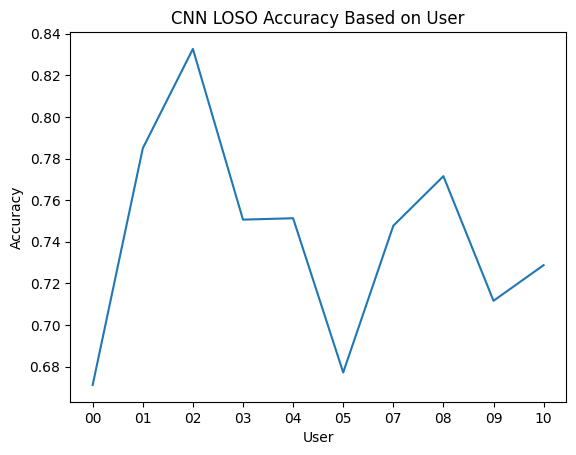

In [213]:
plt.plot(accuracies.keys(), accuracies.values())
plt.xlabel('User')
plt.ylabel('Accuracy')
plt.title('CNN LOSO Accuracy Based on User')
plt.savefig(r"C:\Users\henry\Downloads\Plots\cnn_loso.pdf", format="pdf", bbox_inches="tight")
plt.show()

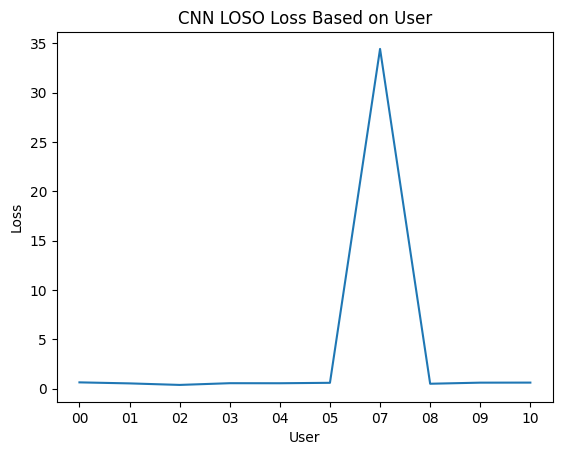

In [214]:
plt.plot(losses.keys(), losses.values())
plt.xlabel('User')
plt.ylabel('Loss')
plt.title('CNN LOSO Loss Based on User')
plt.savefig(r"C:\Users\henry\Downloads\Plots\cnn_loso_loss.pdf", format="pdf", bbox_inches="tight")
plt.show()

Leave-One-Event-Out Deep Learning Models

c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Day 2013-03-27 Accuracy: 0.6301615834236145


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Day 2013-03-28 Accuracy: 0.6471428275108337


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Day 2013-03-29 Accuracy: 0.6635714173316956


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Day 2013-03-30 Accuracy: 0.7457143068313599


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Day 2013-03-31 Accuracy: 0.5680851340293884


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Day 2013-04-01 Accuracy: 0.7661972045898438


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Day 2013-04-02 Accuracy: 0.75


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Day 2013-04-03 Accuracy: 0.8050000071525574


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Day 2013-04-04 Accuracy: 0.8373239636421204


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Day 2013-04-05 Accuracy: 0.717164158821106


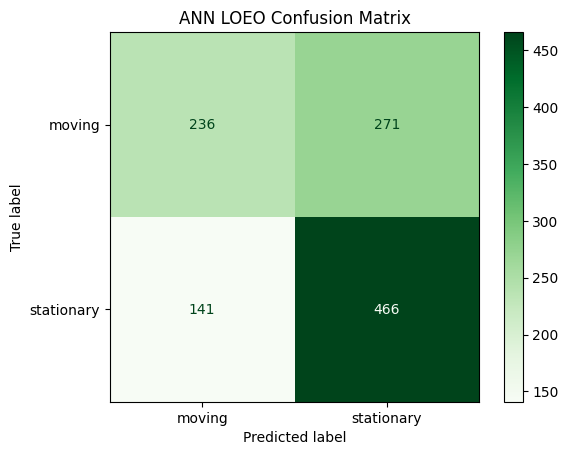

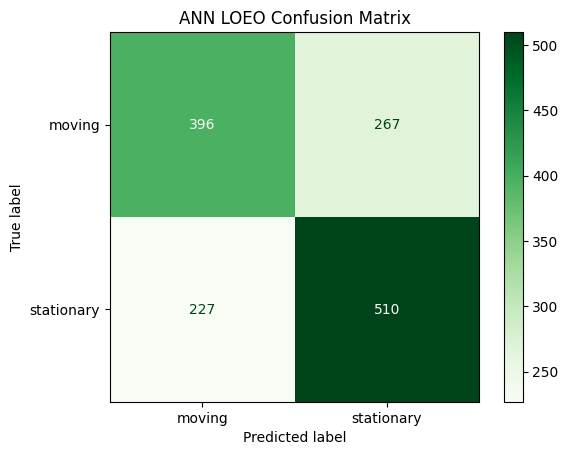

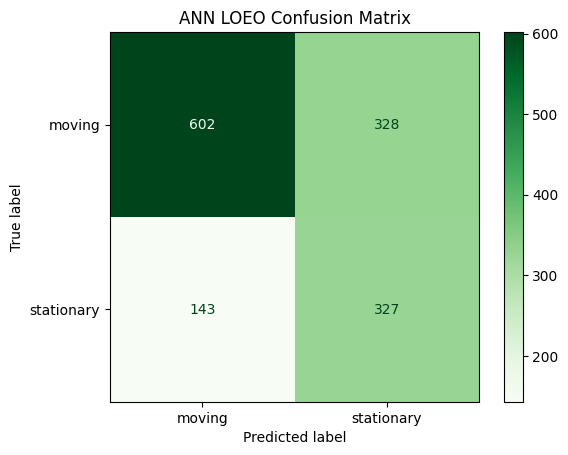

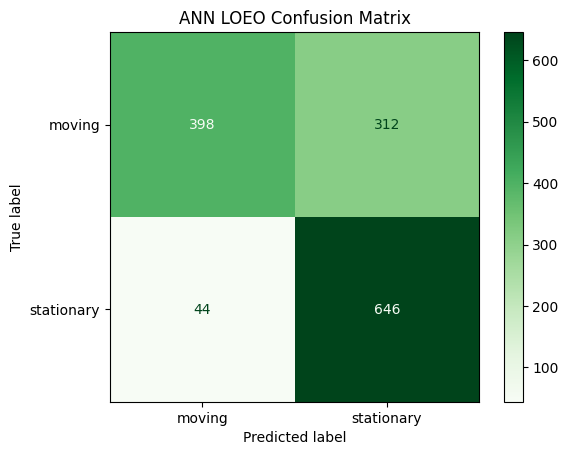

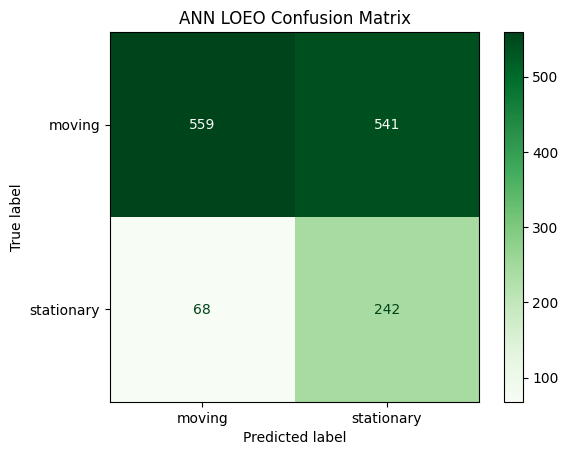

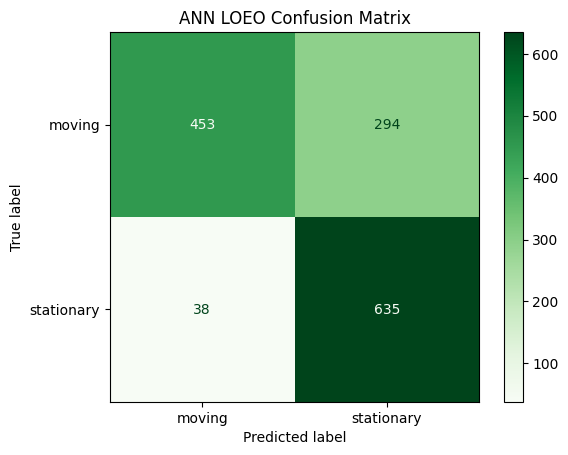

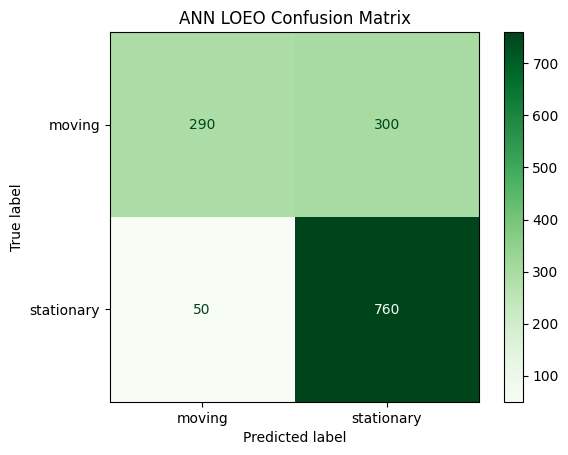

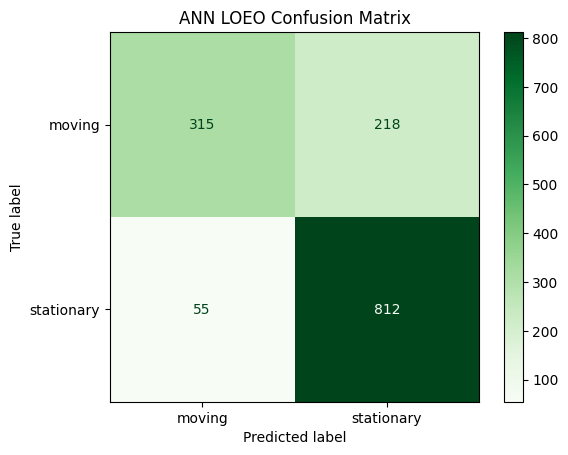

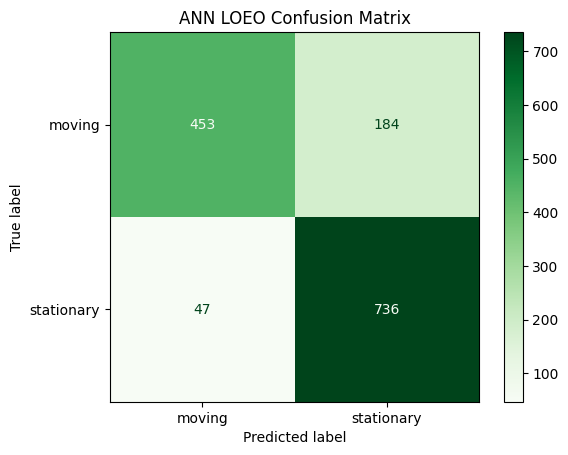

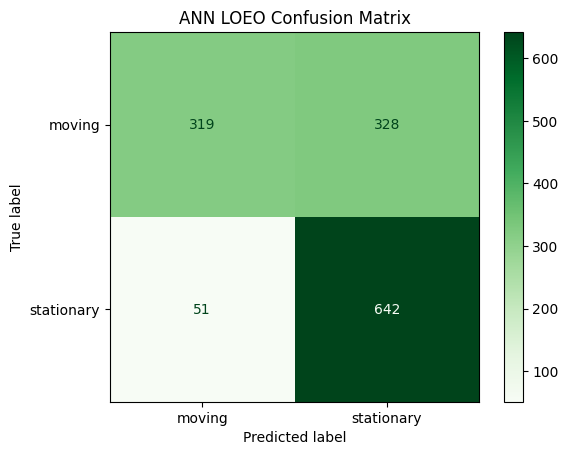

In [215]:
# LOEO

accuracies = {}
losses = {}
firstTenDays = pd.to_datetime(interploated_df['timestamp']).dt.date.drop_duplicates().sort_values().iloc[:10].to_numpy()

for day in firstTenDays:
    test_df = interploated_df[interploated_df['timestamp'].dt.date == day]
    train_df = interploated_df[interploated_df['timestamp'].dt.date != day]

    X_train = np.stack(train_df[['latitude', 'longitude']].values)
    y_train = np.stack(train_df['travelstate'].values)
    X_test  = np.stack(test_df[['latitude', 'longitude']].values)
    y_test  = np.stack(test_df['travelstate'].values)

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    y_train = le.fit_transform(y_train)
    y_test = le.fit_transform(y_test)

    model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid') 
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=64, verbose=0)

    y_pred = model.predict(X_test_scaled)
    y_pred = (y_pred >= 0.5).astype(int)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['moving', 'stationary'])
    disp.plot(cmap='Greens')
    plt.title("ANN LOEO Confusion Matrix")
    plt.savefig(fr"C:\Users\henry\Downloads\Plots\confusion_matrix_ann_loeo_{day}.pdf", format="pdf", bbox_inches="tight")

    loss, acc = model.evaluate(X_test_scaled, y_test, verbose=0)
    print("Day",day,"Accuracy:", acc)   
    accuracies[day] = acc 
    losses[day] = loss

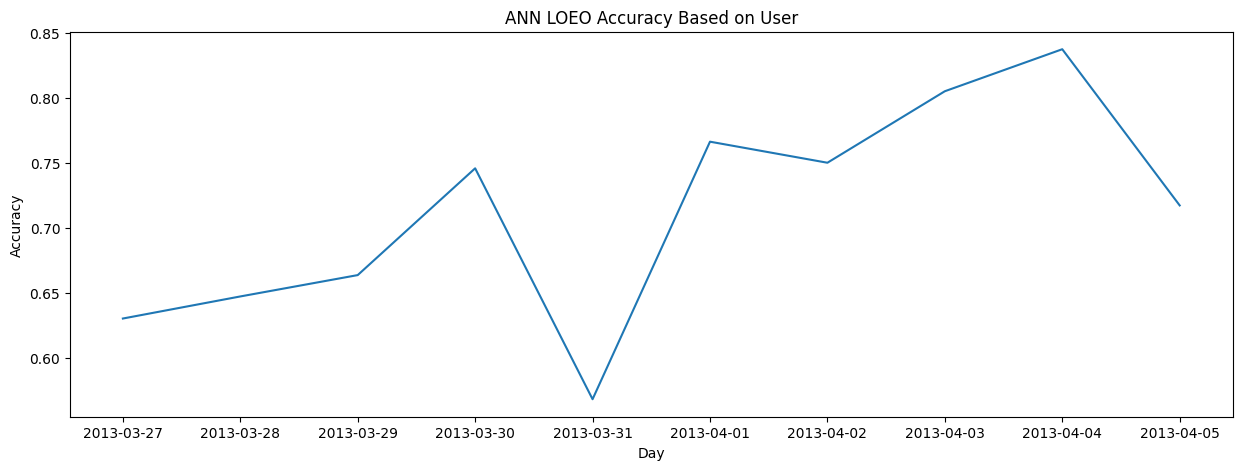

In [216]:
plt.figure(figsize=(15, 5))
plt.plot(accuracies.keys(), accuracies.values())
plt.xlabel('Day')
plt.ylabel('Accuracy')
plt.title('ANN LOEO Accuracy Based on User')
plt.savefig(r"C:\Users\henry\Downloads\Plots\ann_loeo.pdf", format="pdf", bbox_inches="tight")
plt.show()

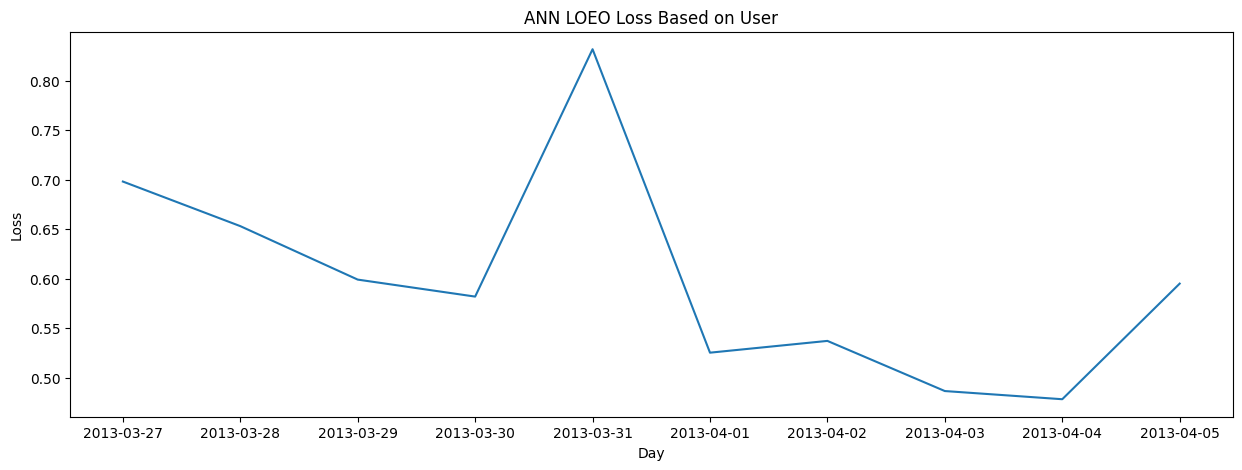

In [217]:
plt.figure(figsize=(15, 5))
plt.plot(losses.keys(), losses.values())
plt.xlabel('Day')
plt.ylabel('Loss')
plt.title('ANN LOEO Loss Based on User')
plt.savefig(r"C:\Users\henry\Downloads\Plots\ann_loeo_loss.pdf", format="pdf", bbox_inches="tight")
plt.show()

c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Day 2013-03-27 Accuracy: 0.6292639374732971


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Day 2013-03-28 Accuracy: 0.645714282989502


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Day 2013-03-29 Accuracy: 0.675000011920929


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Day 2013-03-30 Accuracy: 0.7464285492897034


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Day 2013-03-31 Accuracy: 0.5957446694374084


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Day 2013-04-01 Accuracy: 0.7753521203994751


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Day 2013-04-02 Accuracy: 0.7535714507102966


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Day 2013-04-03 Accuracy: 0.7799999713897705


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Day 2013-04-04 Accuracy: 0.858450710773468


c:\Users\henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Day 2013-04-05 Accuracy: 0.7074626684188843


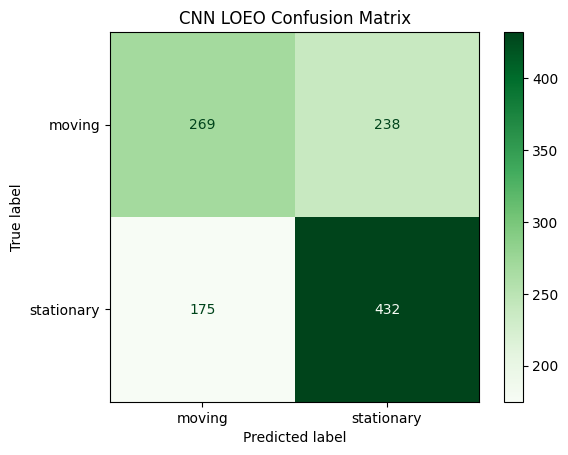

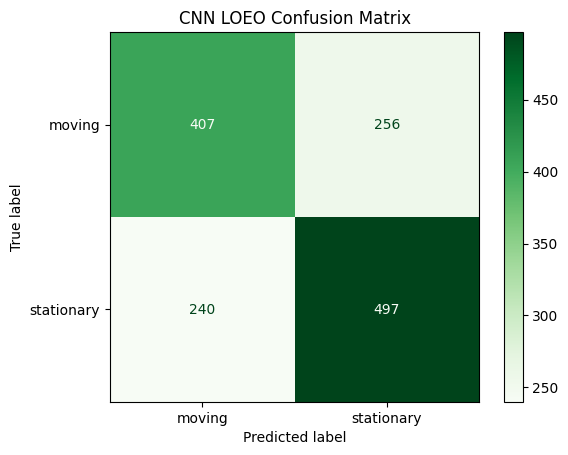

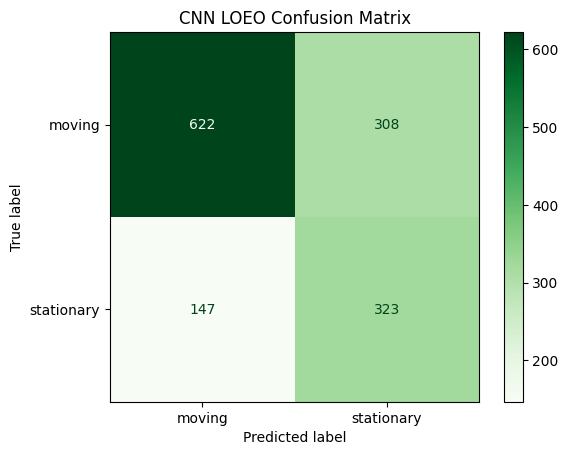

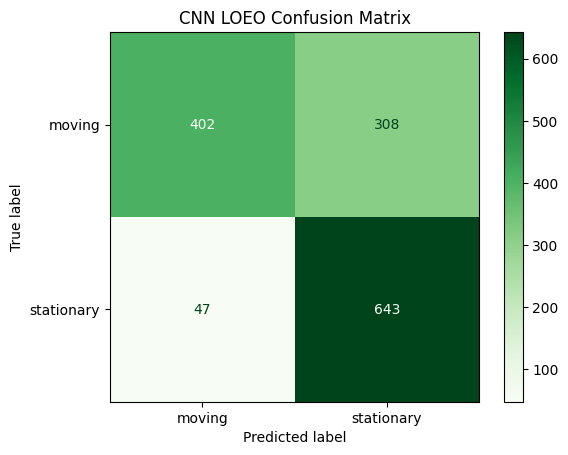

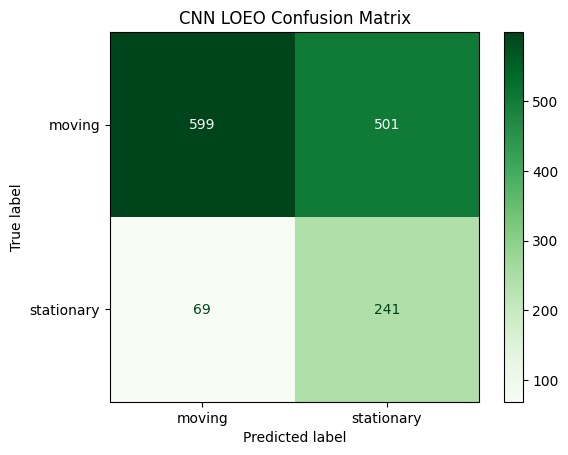

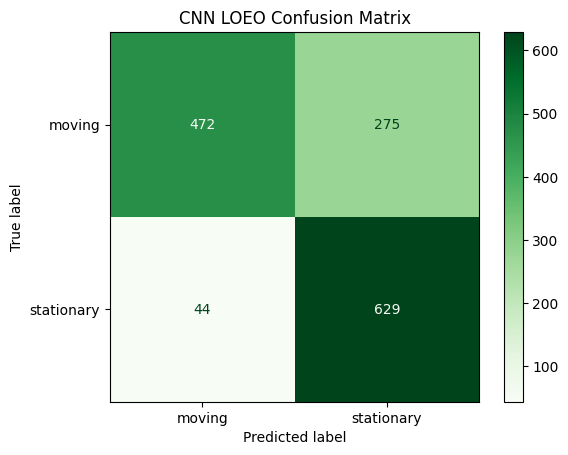

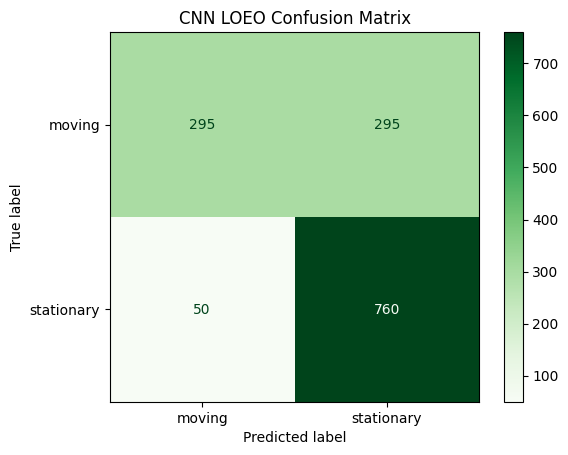

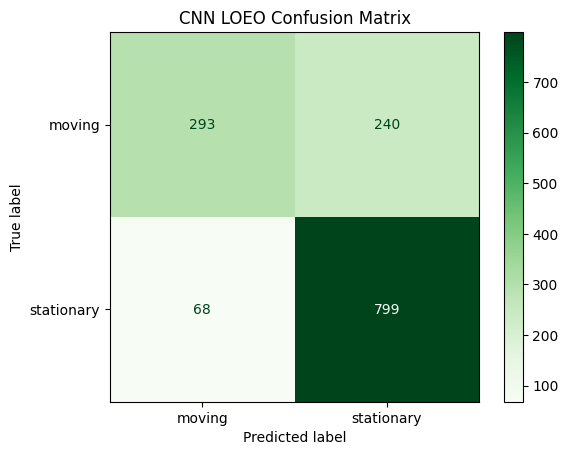

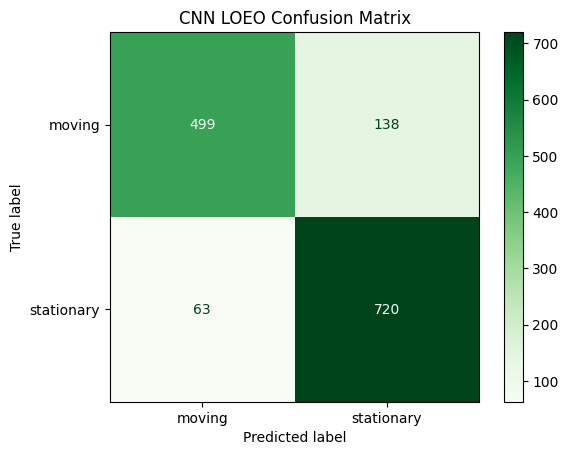

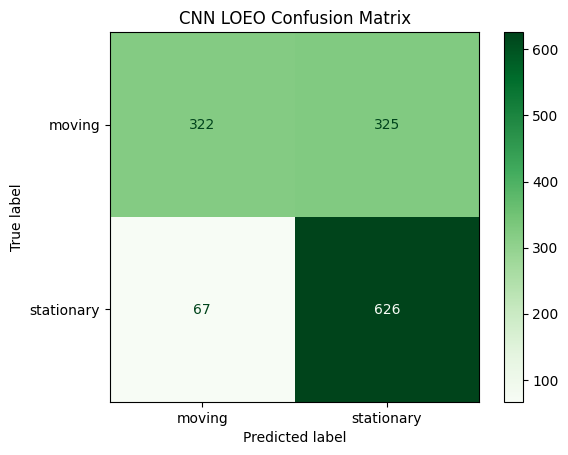

In [219]:
# LOEO

accuracies = {}
losses = {}
firstTenDays = pd.to_datetime(interploated_df['timestamp']).dt.date.drop_duplicates().sort_values().iloc[:10].to_numpy()

for day in firstTenDays:
    test_df = interploated_df[interploated_df['timestamp'].dt.date == day]
    train_df = interploated_df[interploated_df['timestamp'].dt.date != day]

    X_train = np.stack(train_df[['latitude', 'longitude']].values)
    y_train = np.stack(train_df['travelstate'].values)
    X_test  = np.stack(test_df[['latitude', 'longitude']].values)
    y_test  = np.stack(test_df['travelstate'].values)

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)
    X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_scaled  = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    y_train = le.fit_transform(y_train)
    y_test = le.fit_transform(y_test)

    model5 = Sequential([
    Conv1D(32, kernel_size=1, activation='relu', input_shape=(1, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
    ])
    
    model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model5.fit(X_train_scaled, y_train, epochs=50, batch_size=64, verbose=0)

    y_pred = model5.predict(X_test_scaled)
    y_pred = (y_pred >= 0.5).astype(int)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['moving', 'stationary'])
    disp.plot(cmap='Greens')
    plt.title("CNN LOEO Confusion Matrix")
    plt.savefig(fr"C:\Users\henry\Downloads\Plots\confusion_matrix_cnn_loeo_{day}.pdf", format="pdf", bbox_inches="tight")

    loss, acc = model5.evaluate(X_test_scaled, y_test, verbose=0)
    print("Day",day,"Accuracy:", acc)   
    accuracies[day] = acc 
    losses[day] = loss

<h1>Demo2: Advanced Modeling & Transfer Learning</h1>

In [35]:
dfs = []  

for file in sorted(os.listdir("./pre_train_dataset/taxi_log_2008_by_id/"))[:60]:
    df = pd.read_csv(f"./pre_train_dataset/taxi_log_2008_by_id/{file}", header=None)
    df.columns = ['taxi_id', 'timestamp', 'latitude', 'longitude']
    dfs.append(df)

all_taxi = pd.concat(dfs, ignore_index=True)
all_taxi

,taxi_id,timestamp,latitude,longitude
0,1,2008-02-02 15:36:08,116.51172,39.92123
1,1,2008-02-02 15:46:08,116.51135,39.93883
2,1,2008-02-02 15:46:08,116.51135,39.93883
3,1,2008-02-02 15:56:08,116.51627,39.91034
4,1,2008-02-02 16:06:08,116.47186,39.91248
...,...,...,...,...
91303,10050,2008-02-08 17:29:00,116.40372,39.89110
91304,10050,2008-02-08 17:33:38,116.42441,39.89205
91305,10050,2008-02-08 17:34:01,116.42440,39.89208
91306,10050,2008-02-08 17:38:50,116.42469,39.89205


In [36]:
all_taxi['timestamp'] = pd.to_datetime(all_taxi['timestamp'])

all_taxi = all_taxi.sort_values(['taxi_id', 'timestamp'])

def haversine(lat1, lon1, lat2, lon2):
    R = 6371000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

all_taxi['lat_prev'] = all_taxi.groupby('taxi_id')['latitude'].shift(1)
all_taxi['lon_prev'] = all_taxi.groupby('taxi_id')['longitude'].shift(1)
all_taxi['t_prev'] = all_taxi.groupby('taxi_id')['timestamp'].shift(1)

all_taxi['dist_m'] = haversine(
    all_taxi['lat_prev'],
    all_taxi['lon_prev'],
    all_taxi['latitude'],
    all_taxi['longitude']
)

all_taxi['dt_s'] = (all_taxi['timestamp'] - all_taxi['t_prev']).dt.total_seconds()

valid = all_taxi['dt_s'] > 0

all_taxi['speed_mps'] = np.where(
    valid,
    all_taxi['dist_m'] / all_taxi['dt_s'],
    0.0
)

speed_threshold = 0.5
all_taxi['travelstate'] = np.where(
    all_taxi['speed_mps'] < speed_threshold,
    'stationary',
    'moving'
)

first_idx = all_taxi.groupby('taxi_id').head(1).index
all_taxi.loc[first_idx, 'travelstate'] = 'stationary'

all_taxi['label'] = (all_taxi['travelstate'] == 'moving').astype(np.int64)

all_taxi['dt_s'] = all_taxi['dt_s'].fillna(0.0)

all_taxi



,taxi_id,timestamp,latitude,longitude,lat_prev,lon_prev,t_prev,dist_m,dt_s,speed_mps,travelstate,label
0,1,2008-02-02 15:36:08,116.51172,39.92123,NaN,NaN,NaT,NaN,0.0,0.000000,stationary,0
1,1,2008-02-02 15:46:08,116.51135,39.93883,116.51172,39.92123,2008-02-02 15:36:08,874.543686,600.0,1.457573,moving,1
2,1,2008-02-02 15:46:08,116.51135,39.93883,116.51135,39.93883,2008-02-02 15:46:08,0.000000,0.0,0.000000,stationary,0
3,1,2008-02-02 15:56:08,116.51627,39.91034,116.51135,39.93883,2008-02-02 15:46:08,1516.342020,600.0,2.527237,moving,1
4,1,2008-02-02 16:06:08,116.47186,39.91248,116.51627,39.91034,2008-02-02 15:56:08,4939.307535,600.0,8.232179,moving,1
...,...,...,...,...,...,...,...,...,...,...,...,...
91303,10050,2008-02-08 17:29:00,116.40372,39.89110,116.40396,39.89119,2008-02-08 17:28:36,27.055306,24.0,1.127304,moving,1
91304,10050,2008-02-08 17:33:38,116.42441,39.89205,116.40372,39.89110,2008-02-08 17:29:00,2301.102913,278.0,8.277349,moving,1
91305,10050,2008-02-08 17:34:01,116.42440,39.89208,116.42441,39.89205,2008-02-08 17:33:38,1.854776,23.0,0.080642,stationary,0
91306,10050,2008-02-08 17:38:50,116.42469,39.89205,116.42440,39.89208,2008-02-08 17:34:01,32.280682,289.0,0.111698,stationary,0


In [37]:
WINDOW_SIZE = 32
feature_cols = ['latitude', 'longitude', 'dt_s']

X_list = []
y_list = []

for taxi_id, group in all_taxi.groupby('taxi_id'):
    g = group.sort_values('timestamp')
    feats = g[feature_cols].values.astype(np.float32)
    labels = g['label'].values.astype(np.int64)

    if len(g) < WINDOW_SIZE:
        continue

    mean = feats.mean(axis=0, keepdims=True)
    std = feats.std(axis=0, keepdims=True)
    std[std == 0] = 1.0
    feats = (feats - mean) / std

    for i in range(len(g) - WINDOW_SIZE + 1):
        x_win = feats[i:i + WINDOW_SIZE]
        y_win = labels[i + WINDOW_SIZE - 1]
        X_list.append(x_win)
        y_list.append(y_win)

X = np.stack(X_list, axis=0)
y = np.array(y_list)

print("Windowed X shape:", X.shape)
print("Labels shape:", y.shape)
print("Class balance:", np.bincount(y))

Windowed X shape: (89490, 32, 3)
Labels shape: (89490,)
Class balance: [48492 40998]


In [39]:
class TaxiWindowDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

train_ds = TaxiWindowDataset(X_train, y_train)
val_ds = TaxiWindowDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

class CNNTravelState(nn.Module):
    def __init__(self, in_channels=3, hidden_channels=32):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, hidden_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(hidden_channels, hidden_channels * 2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
        )
        self.fc = nn.Linear(hidden_channels * 2, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.conv(x)
        x = x.squeeze(-1)
        logits = self.fc(x)
        return logits.squeeze(-1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNTravelState(in_channels=3, hidden_channels=32).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def run_epoch(loader, training=True):
    if training:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    total = 0
    correct = 0

    with torch.set_grad_enabled(training):
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.float().to(device)

            if training:
                optimizer.zero_grad()

            logits = model(xb)
            loss = criterion(logits, yb)

            if training:
                loss.backward()
                optimizer.step()

            total_loss += loss.item() * xb.size(0)
            total += xb.size(0)

            preds = (torch.sigmoid(logits) > 0.5).long()
            correct += (preds.cpu() == yb.long().cpu()).sum().item()

    return total_loss / total, correct / total

EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = run_epoch(train_loader, training=True)
    val_loss, val_acc = run_epoch(val_loader, training=False)
    print(f"Epoch {epoch:02d} | "
          f"train loss {train_loss:.4f}, acc {train_acc:.3f} | "
          f"val loss {val_loss:.4f}, acc {val_acc:.3f}")

torch.save(model.state_dict(), "cnn_taxi_pretrained.pt")

Epoch 01 | train loss 0.5980, acc 0.696 | val loss 0.5750, acc 0.734
Epoch 02 | train loss 0.5631, acc 0.735 | val loss 0.5561, acc 0.735
Epoch 03 | train loss 0.5478, acc 0.744 | val loss 0.5355, acc 0.750
Epoch 04 | train loss 0.5317, acc 0.754 | val loss 0.5217, acc 0.756
Epoch 05 | train loss 0.5174, acc 0.765 | val loss 0.5078, acc 0.763
Epoch 06 | train loss 0.5030, acc 0.773 | val loss 0.5002, acc 0.772
Epoch 07 | train loss 0.4922, acc 0.781 | val loss 0.4927, acc 0.774
Epoch 08 | train loss 0.4830, acc 0.786 | val loss 0.4863, acc 0.792
Epoch 09 | train loss 0.4740, acc 0.792 | val loss 0.4714, acc 0.787
Epoch 10 | train loss 0.4663, acc 0.796 | val loss 0.4667, acc 0.792


In [42]:
interploated_df['timestamp'] = pd.to_datetime(interploated_df['timestamp'])
interploated_df = interploated_df.sort_values('timestamp')

interploated_df['label'] = (interploated_df['travelstate'] == 'moving').astype(np.int64)

interploated_df['t_prev'] = interploated_df['timestamp'].shift(1)
interploated_df['dt_s'] = (interploated_df['timestamp'] - interploated_df['t_prev']).dt.total_seconds()
interploated_df['dt_s'] = interploated_df['dt_s'].fillna(0.0)
interploated_df['dt_s'] = interploated_df['dt_s'].clip(lower=0.0, upper=3600.0)

feature_cols = ['latitude', 'longitude', 'dt_s']

interploated_df['day'] = interploated_df['timestamp'].dt.date


In [44]:
WINDOW_SIZE = 32
feature_cols = ['latitude', 'longitude', 'dt_s']

X_list_B = []
y_list_B = []
event_list_B = []
subject_list_B = []

clean_df = interploated_df.dropna(subset=feature_cols)

for sid, group in clean_df.groupby("subject_id"):
    g = group.sort_values("timestamp")

    feats = g[feature_cols].values.astype(np.float32)
    labels = g['label'].values.astype(np.int64)
    days = g['day'].values
    subjects = g['subject_id'].values

    if len(g) < WINDOW_SIZE:
        continue

    mean = feats.mean(axis=0, keepdims=True)
    std = feats.std(axis=0, keepdims=True)
    std[std == 0] = 1.0
    feats = (feats - mean) / std

    for i in range(len(g) - WINDOW_SIZE + 1):
        x_win = feats[i:i + WINDOW_SIZE]
        y_win = labels[i + WINDOW_SIZE - 1]
        day = days[i + WINDOW_SIZE - 1]
        sub = subjects[i + WINDOW_SIZE - 1]

        X_list_B.append(x_win)
        y_list_B.append(y_win)
        event_list_B.append(day)
        subject_list_B.append(sub)

X_B = np.stack(X_list_B, axis=0)
y_B = np.array(y_list_B)
event_ids_B = np.array(event_list_B)
subject_ids_B = np.array(subject_list_B)

X_B = np.nan_to_num(X_B, nan=0.0, posinf=0.0, neginf=0.0)

print("Windows shape:", X_B.shape)
print("Labels shape:", y_B.shape)
print("Class balance:", np.bincount(y_B))

unique_days, counts_days = np.unique(event_ids_B, return_counts=True)
print("Unique days and window counts:")
for d, c in zip(unique_days, counts_days):
    print(d, "->", c, "windows")

unique_subj, counts_subj = np.unique(subject_ids_B, return_counts=True)
print("\nUnique subjects and window counts:")
for s, c in zip(unique_subj, counts_subj):
    print(s, "->", c, "windows")


Windows shape: (4281592, 32, 3)
Labels shape: (4281592,)
Class balance: [3588824  692768]
Unique days and window counts:
2013-03-27 -> 35334 windows
2013-03-28 -> 62445 windows
2013-03-29 -> 66135 windows
2013-03-30 -> 66240 windows
2013-03-31 -> 66417 windows
2013-04-01 -> 69342 windows
2013-04-02 -> 70560 windows
2013-04-03 -> 70560 windows
2013-04-04 -> 70560 windows
2013-04-05 -> 70560 windows
2013-04-06 -> 70560 windows
2013-04-07 -> 70560 windows
2013-04-08 -> 70560 windows
2013-04-09 -> 70560 windows
2013-04-10 -> 70560 windows
2013-04-11 -> 70560 windows
2013-04-12 -> 70560 windows
2013-04-13 -> 70560 windows
2013-04-14 -> 70560 windows
2013-04-15 -> 70560 windows
2013-04-16 -> 70560 windows
2013-04-17 -> 70560 windows
2013-04-18 -> 70560 windows
2013-04-19 -> 70560 windows
2013-04-20 -> 70560 windows
2013-04-21 -> 70560 windows
2013-04-22 -> 70560 windows
2013-04-23 -> 70560 windows
2013-04-24 -> 70560 windows
2013-04-25 -> 70323 windows
2013-04-26 -> 69120 windows
2013-04-27 

In [45]:
class WindowDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

Xb_train, Xb_val, yb_train, yb_val = train_test_split(
    X_B, y_B, test_size=0.2, random_state=42, stratify=y_B
)

trainB_ds = WindowDataset(Xb_train, yb_train)
valB_ds = WindowDataset(Xb_val, yb_val)

trainB_loader = DataLoader(trainB_ds, batch_size=64, shuffle=True)
valB_loader = DataLoader(valB_ds, batch_size=64, shuffle=False)

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.BCEWithLogitsLoss()

def run_epoch(model, loader, optimizer=None):
    training = optimizer is not None
    model.train() if training else model.eval()

    total_loss, total, correct = 0.0, 0, 0

    with torch.set_grad_enabled(training):
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.float().to(device)

            if training:
                optimizer.zero_grad()

            logits = model(xb)
            loss = criterion(logits, yb)

            if training:
                loss.backward()
                optimizer.step()

            total_loss += loss.item() * xb.size(0)
            total += xb.size(0)
            preds = (torch.sigmoid(logits) > 0.5).long()
            correct += (preds.cpu() == yb.long().cpu()).sum().item()

    return total_loss / total, correct / total

student_model_frozen = CNNTravelState(in_channels=3, hidden_channels=32).to(device)
state_dict = torch.load("cnn_taxi_pretrained.pt", map_location=device)
student_model_frozen.load_state_dict(state_dict)

for p in student_model_frozen.conv.parameters():
    p.requires_grad = False

optimizer_frozen = optim.Adam(
    filter(lambda p: p.requires_grad, student_model_frozen.parameters()),
    lr=1e-3
)

for epoch in range(1, 11):
    train_loss, train_acc = run_epoch(student_model_frozen, trainB_loader, optimizer_frozen)
    val_loss, val_acc = run_epoch(student_model_frozen, valB_loader, optimizer=None)
    print(f"[StudentLife FROZEN] Epoch {epoch:02d} | "
          f"train loss {train_loss:.4f}, acc {train_acc:.3f} | "
          f"val loss {val_loss:.4f}, acc {val_acc:.3f}")



[StudentLife FROZEN] Epoch 01 | train loss 0.4428, acc 0.838 | val loss 0.4402, acc 0.838
[StudentLife FROZEN] Epoch 02 | train loss 0.4401, acc 0.838 | val loss 0.4402, acc 0.838
[StudentLife FROZEN] Epoch 03 | train loss 0.4398, acc 0.838 | val loss 0.4399, acc 0.838
[StudentLife FROZEN] Epoch 04 | train loss 0.4397, acc 0.838 | val loss 0.4393, acc 0.838
[StudentLife FROZEN] Epoch 05 | train loss 0.4396, acc 0.838 | val loss 0.4392, acc 0.838
[StudentLife FROZEN] Epoch 06 | train loss 0.4395, acc 0.838 | val loss 0.4393, acc 0.838
[StudentLife FROZEN] Epoch 07 | train loss 0.4395, acc 0.838 | val loss 0.4393, acc 0.838
[StudentLife FROZEN] Epoch 08 | train loss 0.4394, acc 0.838 | val loss 0.4391, acc 0.838
[StudentLife FROZEN] Epoch 09 | train loss 0.4394, acc 0.838 | val loss 0.4391, acc 0.838
[StudentLife FROZEN] Epoch 10 | train loss 0.4394, acc 0.838 | val loss 0.4392, acc 0.838


In [47]:
student_model_unfrozen = CNNTravelState(in_channels=3, hidden_channels=32).to(device)
student_model_unfrozen.load_state_dict(torch.load("cnn_taxi_pretrained.pt", map_location=device))

for p in student_model_unfrozen.parameters():
    p.requires_grad = True

optimizer_unfrozen = optim.Adam(student_model_unfrozen.parameters(), lr=1e-4)

for epoch in range(1, 11):
    train_loss, train_acc = run_epoch(student_model_unfrozen, trainB_loader, optimizer_unfrozen)
    val_loss, val_acc = run_epoch(student_model_unfrozen, valB_loader, optimizer=None)
    print(f"[StudentLife UNFROZEN] Epoch {epoch:02d} | "
          f"train loss {train_loss:.4f}, acc {train_acc:.3f} | "
          f"val loss {val_loss:.4f}, acc {val_acc:.3f}")


[StudentLife UNFROZEN] Epoch 01 | train loss 0.4387, acc 0.838 | val loss 0.4372, acc 0.838
[StudentLife UNFROZEN] Epoch 02 | train loss 0.4361, acc 0.838 | val loss 0.4352, acc 0.838
[StudentLife UNFROZEN] Epoch 03 | train loss 0.4353, acc 0.838 | val loss 0.4345, acc 0.838
[StudentLife UNFROZEN] Epoch 04 | train loss 0.4348, acc 0.838 | val loss 0.4345, acc 0.838
[StudentLife UNFROZEN] Epoch 05 | train loss 0.4344, acc 0.838 | val loss 0.4341, acc 0.838
[StudentLife UNFROZEN] Epoch 06 | train loss 0.4341, acc 0.838 | val loss 0.4335, acc 0.838
[StudentLife UNFROZEN] Epoch 07 | train loss 0.4338, acc 0.838 | val loss 0.4347, acc 0.838
[StudentLife UNFROZEN] Epoch 08 | train loss 0.4336, acc 0.838 | val loss 0.4332, acc 0.838
[StudentLife UNFROZEN] Epoch 09 | train loss 0.4334, acc 0.838 | val loss 0.4328, acc 0.838
[StudentLife UNFROZEN] Epoch 10 | train loss 0.4331, acc 0.838 | val loss 0.4327, acc 0.838


In [50]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.BCEWithLogitsLoss()

base_state = torch.load("cnn_taxi_pretrained.pt", map_location=device)

def run_epoch(model, loader, optimizer=None):
    training = optimizer is not None
    if training:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    total = 0
    correct = 0

    with torch.set_grad_enabled(training):
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.float().to(device)

            if training:
                optimizer.zero_grad()

            logits = model(xb)
            loss = criterion(logits, yb)

            if training:
                loss.backward()
                optimizer.step()

            total_loss += loss.item() * xb.size(0)
            total += xb.size(0)

            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).long()
            correct += (preds.view(-1).cpu() == yb.long().view(-1).cpu()).sum().item()

    return total_loss / total, correct / total

unique_events = np.unique(event_ids_B)

if len(unique_events) > 5:
    unique_events = unique_events[:5]

print("Using events (days):", unique_events)

EPOCHS_FT = 5
BATCH_SIZE = 64

fold_val_accs = []

all_y_true = []
all_y_pred = []

for fold_idx, ev_day in enumerate(unique_events, start=1):
    print(f"\nLOEO Fold {fold_idx}")
    print(f"Left-out event (day) = {ev_day}")

    mask_val = (event_ids_B == ev_day)
    mask_train = ~mask_val

    X_train, y_train = X_B[mask_train], y_B[mask_train]
    X_val, y_val = X_B[mask_val], y_B[mask_val]

    print("Train labels:", np.unique(y_train, return_counts=True))
    print("Val labels:", np.unique(y_val, return_counts=True))

    train_ds = WindowDataset(X_train, y_train)
    val_ds = WindowDataset(X_val, y_val)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    model = CNNTravelState(in_channels=3, hidden_channels=32).to(device)
    model.load_state_dict(base_state)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    best_val_acc = 0.0
    for epoch in range(1, EPOCHS_FT + 1):
        train_loss, train_acc = run_epoch(model, train_loader, optimizer)
        val_loss, val_acc = run_epoch(model, val_loader, optimizer=None)

        print(f"Epoch {epoch:02d} | "
              f"train loss {train_loss:.3f}, acc {train_acc:.3f} | "
              f"val loss {val_loss:.3f}, acc {val_acc:.3f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc

    fold_val_accs.append(best_val_acc)
    print(f"Best val acc for day {ev_day}: {best_val_acc:.3f}")

    model.eval()
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.float().to(device)

            logits = model(xb)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).long()

            all_y_true.append(yb.cpu().numpy().ravel())
            all_y_pred.append(preds.cpu().numpy().ravel())

print("\nLOEO Summary (days as events)")
for ev_day, acc in zip(unique_events, fold_val_accs):
    print(f"Day {ev_day}: best val acc = {acc:.3f}")
print(f"Mean val acc across folds = {np.mean(fold_val_accs):.3f}")
print(f"Std  val acc across folds = {np.std(fold_val_accs):.3f}")

y_true_all = np.concatenate(all_y_true)
y_pred_all = np.concatenate(all_y_pred)

cm = confusion_matrix(y_true_all, y_pred_all)
print("\nConfusion matrix across all folds (rows = true, cols = pred):")
print(cm)
print("Labels: 0 = stationary, 1 = moving")


Using events (days): [datetime.date(2013, 3, 27) datetime.date(2013, 3, 28)
 datetime.date(2013, 3, 29) datetime.date(2013, 3, 30)
 datetime.date(2013, 3, 31)]

LOEO Fold 1
Left-out event (day) = 2013-03-27
Train labels: (array([0, 1]), array([3560507,  685751]))
Val labels: (array([0, 1]), array([28317,  7017]))
Epoch 01 | train loss 0.438, acc 0.838 | val loss 0.506, acc 0.801
Epoch 02 | train loss 0.435, acc 0.838 | val loss 0.505, acc 0.801
Epoch 03 | train loss 0.434, acc 0.838 | val loss 0.504, acc 0.801
Epoch 04 | train loss 0.434, acc 0.838 | val loss 0.507, acc 0.801
Epoch 05 | train loss 0.433, acc 0.838 | val loss 0.506, acc 0.801
Best val acc for day 2013-03-27: 0.801

LOEO Fold 2
Left-out event (day) = 2013-03-28
Train labels: (array([0, 1]), array([3536670,  682477]))
Val labels: (array([0, 1]), array([52154, 10291]))
Epoch 01 | train loss 0.438, acc 0.838 | val loss 0.441, acc 0.835
Epoch 02 | train loss 0.436, acc 0.838 | val loss 0.441, acc 0.835
Epoch 03 | train loss 

In [51]:
y_true_all = np.concatenate(all_y_true)
y_pred_all = np.concatenate(all_y_pred)

cm = confusion_matrix(y_true_all, y_pred_all)
print("\nConfusion matrix across all folds (rows = true, cols = pred):")
print(cm)
print("Labels: 0 = stationary, 1 = moving")


Confusion matrix across all folds (rows = true, cols = pred):
[[241644     87]
 [ 54686    154]]
Labels: 0 = stationary, 1 = moving


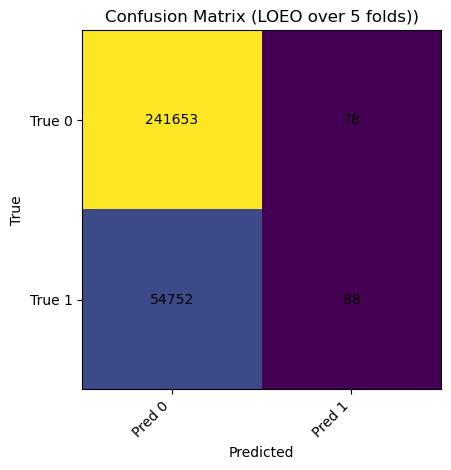

In [52]:
cm = np.array([[241653, 78],
               [54752,  88]])

classes = ["Stationary (0)", "Moving (1)"]

fig, ax = plt.subplots()
im = ax.imshow(cm)

ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(["Pred 0", "Pred 1"])
ax.set_yticklabels(["True 0", "True 1"])

plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j],
                ha="center", va="center")

ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix (LOEO over 5 folds))")

plt.tight_layout()
plt.show()


Using subjects (LOSO): [0 1 2 3 4]

LOSO Fold 1
Left-out subject = 0
Train labels: (array([0, 1]), array([3518070,  668700]))
Val labels: (array([0, 1]), array([70754, 24068]))
Epoch 01 | train loss 0.435, acc 0.840 | val loss 0.592, acc 0.746
Epoch 02 | train loss 0.433, acc 0.840 | val loss 0.594, acc 0.746
Epoch 03 | train loss 0.432, acc 0.840 | val loss 0.603, acc 0.746
Epoch 04 | train loss 0.432, acc 0.840 | val loss 0.588, acc 0.746
Epoch 05 | train loss 0.431, acc 0.840 | val loss 0.601, acc 0.746
Best val acc for subject 0: 0.746

LOSO Fold 2
Left-out subject = 1
Train labels: (array([0, 1]), array([3516304,  674029]))
Val labels: (array([0, 1]), array([72520, 18739]))
Epoch 01 | train loss 0.437, acc 0.839 | val loss 0.525, acc 0.795
Epoch 02 | train loss 0.434, acc 0.839 | val loss 0.525, acc 0.795
Epoch 03 | train loss 0.433, acc 0.839 | val loss 0.526, acc 0.795
Epoch 04 | train loss 0.433, acc 0.839 | val loss 0.530, acc 0.795
Epoch 05 | train loss 0.432, acc 0.839 | val

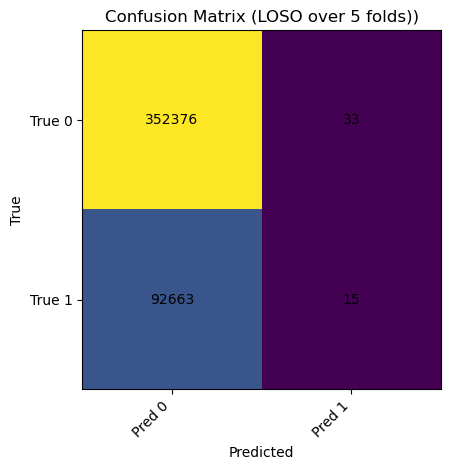

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.BCEWithLogitsLoss()

unique_subjects = np.unique(subject_ids_B)

if len(unique_subjects) > 5:
    unique_subjects = unique_subjects[:5]

print("Using subjects (LOSO):", unique_subjects)

EPOCHS_FT = 5
BATCH_SIZE = 64

fold_val_accs = []

all_y_true = []
all_y_pred = []

for fold_idx, subj in enumerate(unique_subjects, start=1):
    print(f"\nLOSO Fold {fold_idx}")
    print(f"Left-out subject = {subj}")

    mask_val = (subject_ids_B == subj)
    mask_train = ~mask_val

    X_train, y_train = X_B[mask_train], y_B[mask_train]
    X_val, y_val = X_B[mask_val], y_B[mask_val]

    print("Train labels:", np.unique(y_train, return_counts=True))
    print("Val labels:", np.unique(y_val, return_counts=True))

    train_ds = WindowDataset(X_train, y_train)
    val_ds = WindowDataset(X_val, y_val)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    model = CNNTravelState(in_channels=3, hidden_channels=32).to(device)
    model.load_state_dict(base_state)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    best_val_acc = 0.0
    for epoch in range(1, EPOCHS_FT + 1):
        train_loss, train_acc = run_epoch(model, train_loader, optimizer)
        val_loss, val_acc = run_epoch(model, val_loader, optimizer=None)

        print(
            f"Epoch {epoch:02d} | "
            f"train loss {train_loss:.3f}, acc {train_acc:.3f} | "
            f"val loss {val_loss:.3f}, acc {val_acc:.3f}"
        )

        if val_acc > best_val_acc:
            best_val_acc = val_acc

    fold_val_accs.append(best_val_acc)
    print(f"Best val acc for subject {subj}: {best_val_acc:.3f}")

    model.eval()
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device).float()

            logits = model(xb)
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).long()

            all_y_true.append(yb.cpu().numpy())
            all_y_pred.append(preds.cpu().numpy())

print("\nLOSO Summary (subjects as folds)")
for subj, acc in zip(unique_subjects, fold_val_accs):
    print(f"Subject {subj}: best val acc = {acc:.3f}")
print(f"Mean val acc across folds = {np.mean(fold_val_accs):.3f}")
print(f"Std val acc across folds = {np.std(fold_val_accs):.3f}")

y_true_all = np.concatenate(all_y_true)
y_pred_all = np.concatenate(all_y_pred)

cm = confusion_matrix(y_true_all, y_pred_all)
print("\nConfusion matrix across all folds (rows = true, cols = pred):")
print(cm)
print("Labels: 0 = stationary, 1 = moving")

classes = ["Stationary (0)", "Moving (1)"]

fig, ax = plt.subplots()
im = ax.imshow(cm)

ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(["Pred 0", "Pred 1"])
ax.set_yticklabels(["True 0", "True 1"])

plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j],
                ha="center", va="center")

ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix (LOSO over 5 folds))")

plt.tight_layout()
plt.show()


In [54]:
WINDOW_SIZE = 8
feature_cols = ['latitude', 'longitude', 'dt_s']

X_list_B = []
y_list_B = []
event_list_B = []
subject_list_B = []

clean_df = interploated_df.dropna(subset=feature_cols)

for sid, group in clean_df.groupby("subject_id"):
    g = group.sort_values("timestamp")

    feats = g[feature_cols].values.astype(np.float32)
    labels = g['label'].values.astype(np.int64)
    days = g['day'].values
    subjects = g['subject_id'].values

    if len(g) < WINDOW_SIZE:
        continue

    mean = feats.mean(axis=0, keepdims=True)
    std = feats.std(axis=0, keepdims=True)
    std[std == 0] = 1.0
    feats = (feats - mean) / std

    for i in range(len(g) - WINDOW_SIZE + 1):
        x_win = feats[i:i + WINDOW_SIZE]
        y_win = labels[i + WINDOW_SIZE - 1]
        day = days[i + WINDOW_SIZE - 1]
        sub = subjects[i + WINDOW_SIZE - 1]

        X_list_B.append(x_win)
        y_list_B.append(y_win)
        event_list_B.append(day)
        subject_list_B.append(sub)

X_B = np.stack(X_list_B, axis=0)
y_B = np.array(y_list_B)
event_ids_B = np.array(event_list_B)
subject_ids_B = np.array(subject_list_B)

X_B = np.nan_to_num(X_B, nan=0.0, posinf=0.0, neginf=0.0)

print("Windows shape:", X_B.shape)
print("Labels shape:", y_B.shape)
print("Class balance:", np.bincount(y_B))

unique_days, counts_days = np.unique(event_ids_B, return_counts=True)
print("Unique days and window counts:")
for d, c in zip(unique_days, counts_days):
    print(d, "->", c, "windows")

unique_subj, counts_subj = np.unique(subject_ids_B, return_counts=True)
print("\nUnique subjects and window counts:")
for s, c in zip(unique_subj, counts_subj):
    print(s, "->", c, "windows")

Xb_train, Xb_val, yb_train, yb_val = train_test_split(
    X_B, y_B, test_size=0.2, random_state=42, stratify=y_B
)

trainB_ds = WindowDataset(Xb_train, yb_train)
valB_ds = WindowDataset(Xb_val, yb_val)

trainB_loader = DataLoader(trainB_ds, batch_size=64, shuffle=True)
valB_loader = DataLoader(valB_ds, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.BCEWithLogitsLoss()

def run_epoch(model, loader, optimizer=None):
    training = optimizer is not None
    model.train() if training else model.eval()

    total_loss, total, correct = 0.0, 0, 0

    with torch.set_grad_enabled(training):
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.float().to(device)

            if training:
                optimizer.zero_grad()

            logits = model(xb)
            loss = criterion(logits, yb)

            if training:
                loss.backward()
                optimizer.step()

            total_loss += loss.item() * xb.size(0)
            total += xb.size(0)
            preds = (torch.sigmoid(logits) > 0.5).long()
            correct += (preds.cpu() == yb.long().cpu()).sum().item()

    return total_loss / total, correct / total


student_model_frozen = CNNTravelState(in_channels=3, hidden_channels=32).to(device)
state_dict = torch.load("cnn_taxi_pretrained.pt", map_location=device)
student_model_frozen.load_state_dict(state_dict)

for p in student_model_frozen.conv.parameters():
    p.requires_grad = False

optimizer_frozen = optim.Adam(
    filter(lambda p: p.requires_grad, student_model_frozen.parameters()),
    lr=1e-3
)

for epoch in range(1, 11):
    train_loss, train_acc = run_epoch(student_model_frozen, trainB_loader, optimizer_frozen)
    val_loss, val_acc = run_epoch(student_model_frozen, valB_loader, optimizer=None)
    print(f"[StudentLife FROZEN] Epoch {epoch:02d} | "
          f"train loss {train_loss:.4f}, acc {train_acc:.3f} | "
          f"val loss {val_loss:.4f}, acc {val_acc:.3f}")

student_model_unfrozen = CNNTravelState(in_channels=3, hidden_channels=32).to(device)
student_model_unfrozen.load_state_dict(torch.load("cnn_taxi_pretrained.pt", map_location=device))

for p in student_model_unfrozen.parameters():
    p.requires_grad = True

optimizer_unfrozen = optim.Adam(student_model_unfrozen.parameters(), lr=1e-4)

for epoch in range(1, 11):
    train_loss, train_acc = run_epoch(student_model_unfrozen, trainB_loader, optimizer_unfrozen)
    val_loss, val_acc = run_epoch(student_model_unfrozen, valB_loader, optimizer=None)
    print(f"[StudentLife UNFROZEN] Epoch {epoch:02d} | "
          f"train loss {train_loss:.4f}, acc {train_acc:.3f} | "
          f"val loss {val_loss:.4f}, acc {val_acc:.3f}")

Windows shape: (4282768, 8, 3)
Labels shape: (4282768,)
Class balance: [3589851  692917]
Unique days and window counts:
2013-03-27 -> 36366 windows
2013-03-28 -> 62493 windows
2013-03-29 -> 66159 windows
2013-03-30 -> 66240 windows
2013-03-31 -> 66441 windows
2013-04-01 -> 69390 windows
2013-04-02 -> 70560 windows
2013-04-03 -> 70560 windows
2013-04-04 -> 70560 windows
2013-04-05 -> 70560 windows
2013-04-06 -> 70560 windows
2013-04-07 -> 70560 windows
2013-04-08 -> 70560 windows
2013-04-09 -> 70560 windows
2013-04-10 -> 70560 windows
2013-04-11 -> 70560 windows
2013-04-12 -> 70560 windows
2013-04-13 -> 70560 windows
2013-04-14 -> 70560 windows
2013-04-15 -> 70560 windows
2013-04-16 -> 70560 windows
2013-04-17 -> 70560 windows
2013-04-18 -> 70560 windows
2013-04-19 -> 70560 windows
2013-04-20 -> 70560 windows
2013-04-21 -> 70560 windows
2013-04-22 -> 70560 windows
2013-04-23 -> 70560 windows
2013-04-24 -> 70560 windows
2013-04-25 -> 70323 windows
2013-04-26 -> 69120 windows
2013-04-27 -

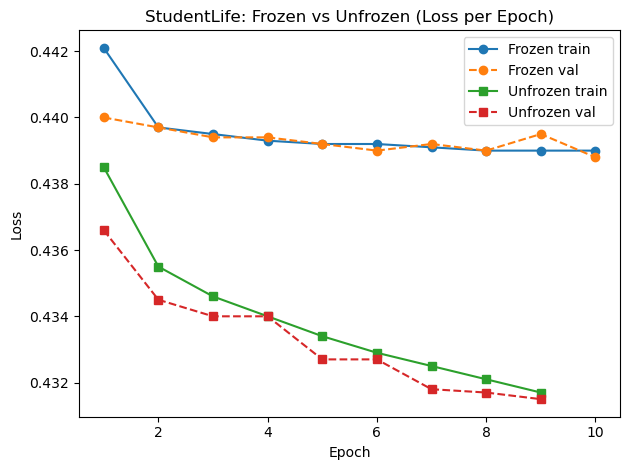

In [55]:
epochs_frozen = np.arange(1, 11)
epochs_unfrozen = np.arange(1, 10)

frozen_train_loss = [0.4421, 0.4397, 0.4395, 0.4393, 0.4392,
                     0.4392, 0.4391, 0.4390, 0.4390, 0.4390]
frozen_val_loss = [0.4400, 0.4397, 0.4394, 0.4394, 0.4392,
                     0.4390, 0.4392, 0.4390, 0.4395, 0.4388]

unfrozen_train_loss = [0.4385, 0.4355, 0.4346, 0.4340, 0.4334,
                   0.4329, 0.4325, 0.4321, 0.4317]
unfrozen_val_loss = [0.4366, 0.4345, 0.4340, 0.4340, 0.4327,
                   0.4327, 0.4318, 0.4317, 0.4315]

plt.figure()

plt.plot(epochs_frozen, frozen_train_loss, marker='o', label='Frozen train')
plt.plot(epochs_frozen, frozen_val_loss, marker='o', linestyle='--', label='Frozen val')

plt.plot(epochs_unfrozen, unfrozen_train_loss, marker='s', label='Unfrozen train')
plt.plot(epochs_unfrozen, unfrozen_val_loss, marker='s', linestyle='--', label='Unfrozen val')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("StudentLife: Frozen vs Unfrozen (Loss per Epoch)")
plt.legend()
plt.tight_layout()
plt.show()


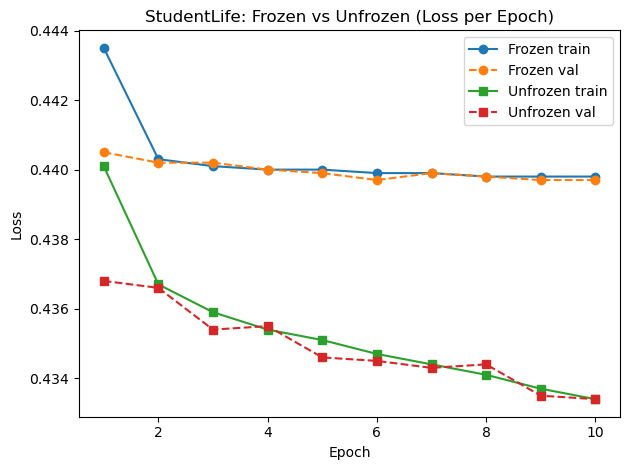

In [56]:
epochs = np.arange(1, 11)

frozen_train_loss = [0.4435, 0.4403, 0.4401, 0.4400, 0.4400,
                     0.4399, 0.4399, 0.4398, 0.4398, 0.4398]
frozen_val_loss = [0.4405, 0.4402, 0.4402, 0.4400, 0.4399,
                     0.4397, 0.4399, 0.4398, 0.4397, 0.4397]

unfrozen_train_loss = [0.4401, 0.4367, 0.4359, 0.4354, 0.4351,
                   0.4347, 0.4344, 0.4341, 0.4337, 0.4334]
unfrozen_val_loss = [0.4368, 0.4366, 0.4354, 0.4355, 0.4346,
                   0.4345, 0.4343, 0.4344, 0.4335, 0.4334]

plt.figure()

plt.plot(epochs, frozen_train_loss, marker='o', label='Frozen train')
plt.plot(epochs, frozen_val_loss, marker='o', linestyle='--', label='Frozen val')

plt.plot(epochs, unfrozen_train_loss, marker='s', label='Unfrozen train')
plt.plot(epochs, unfrozen_val_loss, marker='s', linestyle='--', label='Unfrozen val')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("StudentLife: Frozen vs Unfrozen (Loss per Epoch)")
plt.legend()
plt.tight_layout()
plt.show()
